In [1]:
import base64
import os
import ssl
import re
import random
from urllib import request
import cv2
import numpy as np
import ffmpeg
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

## データセットの準備

In [3]:
UCF_ROOT_URL = 'https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/'
context = ssl._create_unverified_context()

def ucf_label2name_dict():
  idx = request.urlopen(UCF_ROOT_URL, context=context).read().decode('utf-8')
  videos = sorted(list(set(re.findall('(v_[\w_]+\.avi)', idx))))
  output = {}
  for video in videos:
    label = re.findall('v_(.*)_g', video)[0]
    output.setdefault(label, []).append(video)
  return output

def fetch_ucf_video(video, destination):
  urlpath = request.urljoin(UCF_ROOT_URL, video)
  print(f'Fetching {urlpath} -> {destination}')
  data = request.urlopen(urlpath, context=context).read()
  open(destination, "wb").write(data)
  return destination

def prepare_ucf_dataset(destination='ucf101', num_per_class=None, random_sample=False):
  cnt = 0
  for label, videos in tqdm(ucf_label2name_dict().items()):
    if num_per_class:
      if random_sample:
        videos = random.sample(videos, num_per_class)
      else:
        videos = videos[:num_per_class]
    for video in videos:
      data_name = re.findall('(.*).avi', video)[0]
      data_dir = os.path.join(destination, label, data_name)
      os.makedirs(data_dir, exist_ok=True)
      video_dest = os.path.join(data_dir, video)
      audio_dest = os.path.join(data_dir, video.replace('.avi', '.wav'))
      if not os.path.exists(video_dest):
        fetch_ucf_video(video, video_dest)
        try:
          ffmpeg.run(ffmpeg.output(ffmpeg.input(video_dest), audio_dest))
        except:
          shutil.rmtree(os.path.join(destination, label))
          break
        cnt += 1
  return cnt

In [4]:
print('video count:', prepare_ucf_dataset(num_per_class=200))

In [4]:
import torch
import torchaudio
from pytorchvideo.transforms import Permute
import matplotlib.pyplot as plt

def crop_center_square(frame):
  h, w = frame.shape[0:2]
  min_dim = min(h, w)
  sx = (w//2) - (min_dim//2)
  sy = (h//2) - (min_dim//2)
  return frame[sy : sy+min_dim, sx : sx+min_dim]

def load_video(path, n_frames=None):
  cap = cv2.VideoCapture(path)
  frames=[]
  frame_rate = cap.get(cv2.CAP_PROP_FPS)
  if not n_frames:
    n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  try:
    while True:
      ret, frame = cap.read()
      if not ret: break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, (224, 224))
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      if n_frames:
        if len(frames) == n_frames : break
  finally:
    cap.release()
  video_tensor = torch.tensor(frames) / 255.0
  video_tensor = torch.permute(video_tensor, (0, 3, 1, 2)) # THWC -> TCHW
  video_shape = video_tensor.shape
  if video_shape[0] < n_frames:
    pad = torch.zeros((n_frames - video_shape[0], video_shape[1], video_shape[2], video_shape[3]))
    video_tensor = torch.concat((video_tensor, pad))
  return video_tensor, frame_rate

def load_audio(path, samples_per_frame=None, video_frame_rate=None, n_video_frames=None):
  waveform, raw_sample_rate = torchaudio.load(path)
  if samples_per_frame and video_frame_rate:
    sample_rate = samples_per_frame * video_frame_rate
    waveform = torchaudio.transforms.Resample(raw_sample_rate, sample_rate)(waveform)
  else: sample_rate = raw_sample_rate
  if waveform.shape[0] != 1:
    waveform = torch.mean(waveform, dim=0) #stereo -> mono
  waveform = waveform.squeeze().unsqueeze(1)
  if samples_per_frame and n_video_frames:
    n_samples = samples_per_frame * n_video_frames
    if waveform.shape[0] < n_samples:
      pad = torch.zeros(n_samples - waveform.shape[0], 1)
      waveform = torch.concat((waveform, pad))
    else:
      waveform = waveform[:n_samples]
  return waveform, sample_rate


In [5]:
video, fps = load_video('ucf101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01/v_ApplyEyeMakeup_g01_c01.avi', 16)
print(video.shape)
print(fps)

torch.Size([16, 3, 224, 224])
25.0


/tmp/ipykernel_158725/3423768512.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  video_tensor = torch.tensor(frames) / 255.0


In [6]:
audio, sample_rate = load_audio('ucf101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01/v_ApplyEyeMakeup_g01_c01.wav', samples_per_frame=1920, video_frame_rate=fps, n_video_frames=16)
print(audio.shape)
print(sample_rate)

torch.Size([30720, 1])
48000.0


In [7]:
import torchvision
from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset
import torch.nn.functional as F

def loader(path, n_frames, audio_samples_per_frame):
  datum = os.listdir(path)
  for data in datum:
    if data.endswith('.avi'):
      video, fps = load_video(os.path.join(path, data), n_frames=n_frames)
  for data in datum:
    if data.endswith('.wav'):
      audio, _ = load_audio(os.path.join(path, data),
                            samples_per_frame=audio_samples_per_frame,
                            video_frame_rate=fps,
                            n_video_frames=n_frames)
  return video, audio


class UCFDataset(DatasetFolder):
  def __init__(self, root, loader, n_video_frames=None, audio_samples_per_frame=None):
    self.root = root
    self.loader = loader
    self.n_frames = n_video_frames
    self.audio_samples_per_frames = audio_samples_per_frame
    self.classes, self.class_to_idx = super().find_classes(root)
    self.samples = self.make_dataset(self.root, self.class_to_idx)

  def make_dataset(self, directory, class_to_idx):
    instances = []
    for target_class in sorted(class_to_idx.keys()):
      class_idx = class_to_idx[target_class]
      target_dir = os.path.join(directory, target_class)
      if not os.path.isdir(target_dir):
        continue
      for data_name in sorted(os.listdir(target_dir)):
        path = os.path.join(target_dir, data_name)
        # item = path, F.one_hot(torch.tensor(class_idx), num_classes=self.num_labels)
        item = path, torch.tensor(class_idx)
        instances.append(item)
    return instances

  def __getitem__(self, idx):
    path, target = self.samples[idx]
    (video, audio) = self.loader(path, self.n_frames, self.audio_samples_per_frames)
    return video, audio, target
  
  @property
  def num_labels(self):
    return len(os.listdir(self.root))
  
  @property
  def id2label(self):
    return {v:k for k,v in self.class_to_idx.items()}
  
  @property
  def label2id(self):
    return self.class_to_idx


class SetTransform(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, idx):
    video, audio, label = self.dataset[idx]
    video = self.transform(video)
    return video, audio, label

  def __len__(self):
    return len(self.dataset)


In [8]:
from torchvision.transforms import (Compose,
                                    Resize)
from transformers import PerceiverForMultimodalAutoencoding

pretrained_model = PerceiverForMultimodalAutoencoding.from_pretrained("deepmind/multimodal-perceiver")
all_dataset = UCFDataset('ucf101',
                         loader=loader,
                         n_video_frames=pretrained_model.config.num_frames,
                         audio_samples_per_frame=pretrained_model.config.audio_samples_per_frame)
len(all_dataset)

6586

In [13]:
val_size = 1000
test_size = 1000
train_size = len(all_dataset) - val_size - test_size

seed = 0
test_dataset, trainval_dataset = torch.utils.data.random_split(all_dataset, [test_size, train_size + val_size], generator=torch.Generator().manual_seed(seed))
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

print('train:', len(train_dataset))
print('validation:', len(val_dataset))
print('test:', len(test_dataset))

train: 4586
validation: 1000
test: 1000


100%|██████████| 4586/4586 [00:00<00:00, 1082020.48it/s]


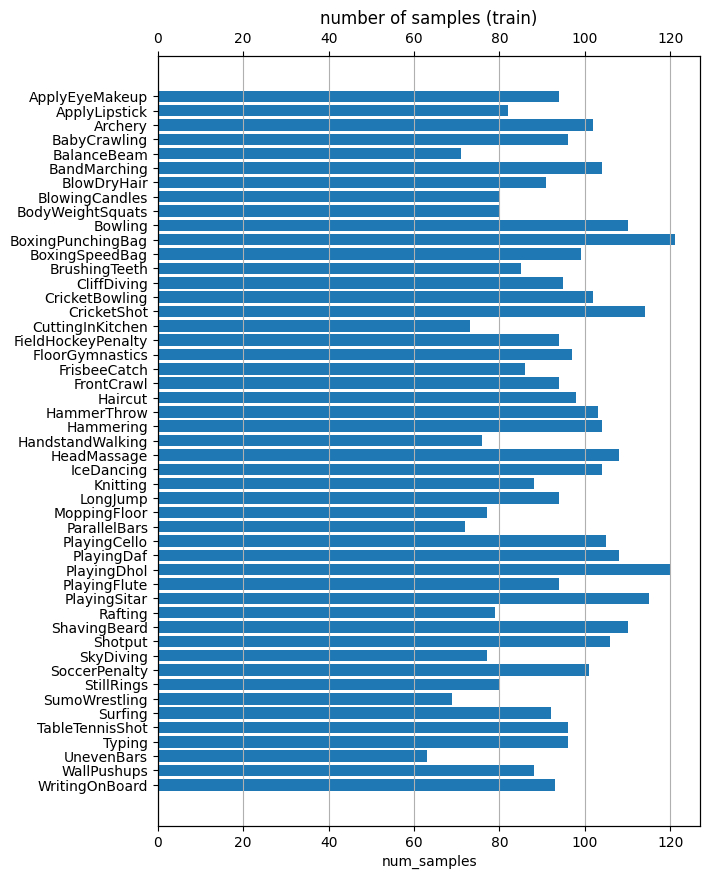

100%|██████████| 1000/1000 [00:00<00:00, 973834.22it/s]


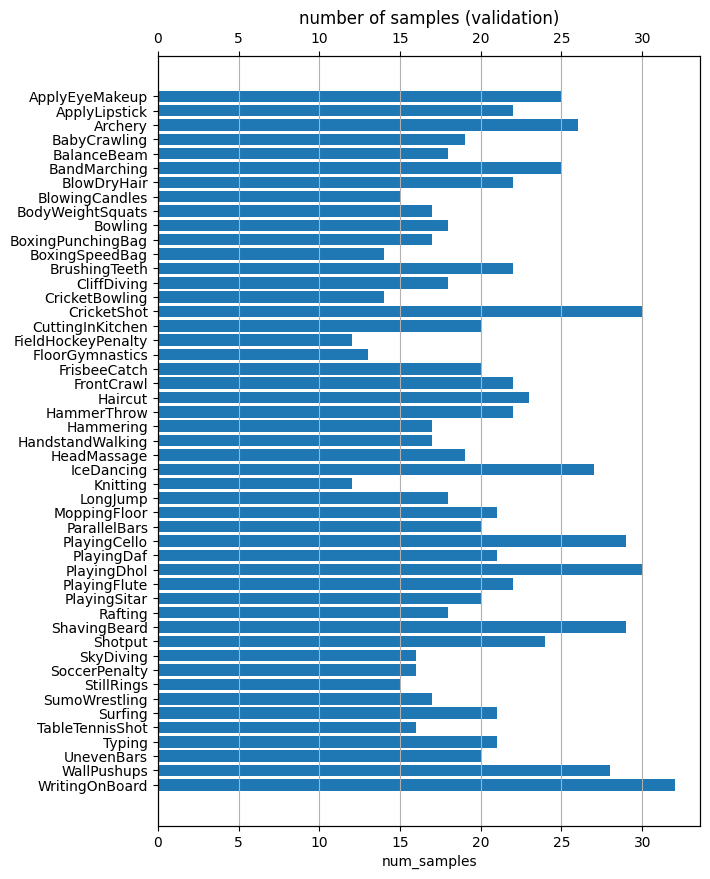

100%|██████████| 1000/1000 [00:00<00:00, 1080727.65it/s]


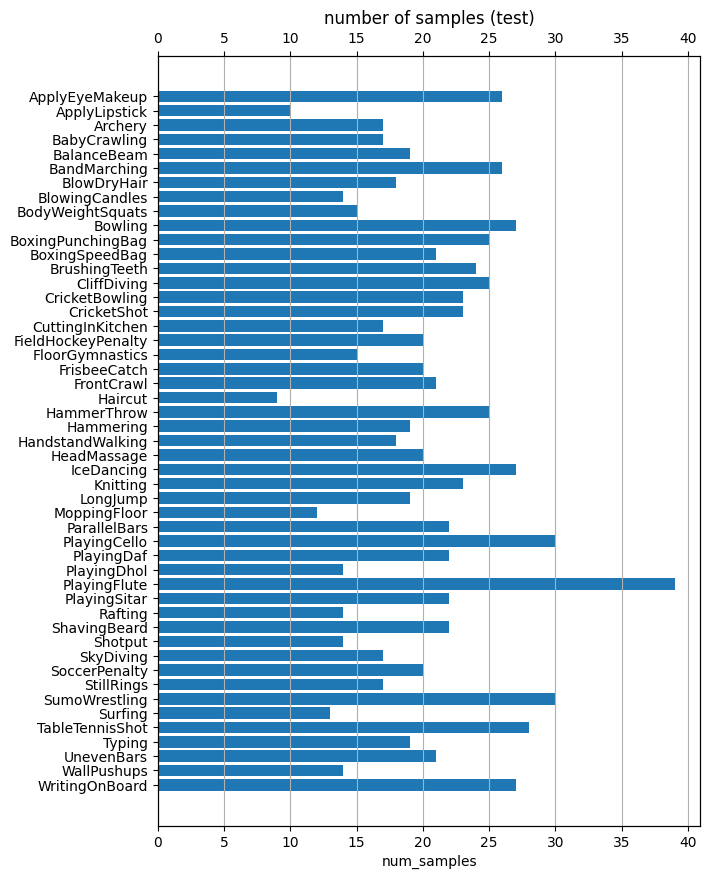

In [37]:
from torch.utils.data import Subset

def plot_n_samples_per_class(ax, dataset, whole_dataset, labels, title=None):
    l = [0]*len(labels)
    for idx in tqdm(dataset.indices):
        parent = None
        if issubclass(type(dataset), Subset) and not isinstance(dataset.dataset, type(whole_dataset)):
            parent = dataset.dataset
            idx = parent.indices[idx]
        _, label = whole_dataset.samples[idx]
        label = label.tolist()
        l[label] += 1
    x = np.arange(1, len(labels) + 1)
    ax.barh(y=x, width=l, tick_label=labels)
    ax.invert_yaxis()
    if title: ax.set_title(f'number of samples ({title})')
    ax.set_xlabel('num_samples')
    ax.grid(axis='x')
    twin_ax = ax.twiny()
    twin_ax.set_xlim(*ax.get_xlim())

labels = list(all_dataset.label2id.keys())

for i, (title, ds) in enumerate(zip(['train', 'validation', 'test'], [train_dataset, val_dataset, test_dataset])):
    fig, ax = plt.subplots(figsize=(7,10))
    plot_n_samples_per_class(ax, ds, all_dataset, labels, title)
    # fig.autofmt_xdate(rotation=90)
    plt.show()

In [11]:
video, audio, label = all_dataset[0]
print(video.shape)
print(audio.shape)
print(label.shape)

torch.Size([16, 3, 224, 224])
torch.Size([30720, 1])
torch.Size([])


In [12]:
def collate_fn(examples):
    videos, audios, labels = zip(*examples)
    videos = torch.stack(videos)
    audios = torch.stack(audios)
    labels = torch.stack(labels)
    return {'image': videos, 'audio': audios, 'labels': labels}

In [52]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)

batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, dict):
        print(k)
        for k_,v_ in v.items():
            print('\t', k_, v_.shape)
    elif isinstance(v, torch.Tensor):
        print(k, v.shape)

image torch.Size([1, 16, 3, 224, 224])
audio torch.Size([1, 30720, 1])
labels torch.Size([1])


In [14]:
from transformers import PerceiverPreTrainedModel, PerceiverModel
from transformers.models.perceiver.modeling_perceiver import (PerceiverConfig,
                                                              PerceiverImagePreprocessor,
                                                              PerceiverAudioPreprocessor,
                                                              PerceiverOneHotPreprocessor,
                                                              PerceiverMultimodalPreprocessor,
                                                              PerceiverClassificationDecoder,
                                                              PerceiverMultimodalDecoder,
                                                              PerceiverClassificationPostprocessor,
                                                              PerceiverClassifierOutput)
from torch.nn import MSELoss, CrossEntropyLoss, BCEWithLogitsLoss

class PerceiverForMultimodalClassification(PerceiverPreTrainedModel):
    def __init__(self, config: PerceiverConfig):
        super().__init__(config)
        
        self.num_labels = config.num_labels
        
        n_audio_samples = config.num_frames * config.audio_samples_per_frame
        input_preprocessor = PerceiverMultimodalPreprocessor(
            min_padding_size=4,
            modalities={
                "audio": PerceiverAudioPreprocessor(
                    config,
                    position_encoding_type="fourier",
                    fourier_position_encoding_kwargs=dict(
                        num_bands=192,
                        max_resolution=(n_audio_samples,),
                        sine_only=False,
                        concat_pos=True,
                    ),
                    prep_type="patches",
                    samples_per_patch=config.samples_per_patch,
                ),
                "image": PerceiverImagePreprocessor(
                    config,
                    position_encoding_type="fourier",
                    fourier_position_encoding_kwargs=dict(
                        num_bands=32,
                        max_resolution=(config.num_frames, config.image_size, config.image_size),
                        sine_only=False,
                        concat_pos=True,
                    ),
                    prep_type="patches",
                    spatial_downsample=4,
                    temporal_downsample=1,
                ),
                "label": PerceiverOneHotPreprocessor(config),
            },
            mask_probs={"image": 0.0, "audio": 0.0, "label": 1.0},
        )
        
        decoder = PerceiverMultimodalDecoder(
            config,
            concat_preprocessed_input=False,
            modalities={
                "label": PerceiverClassificationDecoder(
                    config,
                    concat_preprocessed_input=False,
                    use_query_residual=False,
                    position_encoding_only=True,
                    position_encoding_type="trainable",
                    trainable_position_encoding_kwargs=dict(
                        num_channels=1024,
                        index_dims=1,
                    ),
                ),
            },
            num_outputs=None,
            output_num_channels=512,
            use_query_residual=False,
        )
        
        # decoder = PerceiverClassificationDecoder(
        #     config,
        #     # num_channels=config.d_latents,
        #     concat_preprocessed_input=False,
        #     use_query_residual=False,
        #     position_encoding_only=True,
        #     position_encoding_type="none",
        #     trainable_position_encoding_kwargs=dict(
        #         num_channels=1024,
        #         index_dims=1,
        #     ),
        # )
        
        output_postprocesser = PerceiverClassificationPostprocessor(
            config,
            in_channels=512
        )
        
        self.perceiver = PerceiverModel(
            config,
            input_preprocessor=input_preprocessor,
            decoder=decoder,
            output_postprocessor=output_postprocesser
        )
        
        self.post_init()
    
    def forward(
        self,
        image=None,
        audio=None,
        attention_mask=None,
        subsampled_output_points=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        labels=None,
        return_dict=None,
    ):
        return_dict = self.config.use_return_dict
        inputs = {
            'image': image,
            'audio': audio,
            'label': F.one_hot(labels, num_classes=self.num_labels),
        }
        outputs = self.perceiver(
            inputs=inputs,
            attention_mask=attention_mask,
            subsampled_output_points=subsampled_output_points,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        logits = outputs.logits if return_dict else outputs[0]

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"
            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return PerceiverClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

In [15]:
model = PerceiverForMultimodalClassification.from_pretrained("deepmind/multimodal-perceiver",
                                                             num_labels=all_dataset.num_labels,
                                                             id2label=all_dataset.id2label,
                                                             label2id=all_dataset.label2id,
                                                             ignore_mismatched_sizes=True)

Some weights of the model checkpoint at deepmind/multimodal-perceiver were not used when initializing PerceiverForMultimodalClassification: ['perceiver.decoder.padding.image', 'perceiver.output_postprocessor.modalities.image.classifier.bias', 'perceiver.decoder.padding.audio', 'perceiver.output_postprocessor.modalities.audio.classifier.bias', 'perceiver.output_postprocessor.modalities.image.classifier.weight', 'perceiver.output_postprocessor.modalities.label.classifier.bias', 'perceiver.output_postprocessor.modalities.audio.classifier.weight', 'perceiver.output_postprocessor.modalities.label.classifier.weight']
- This IS expected if you are initializing PerceiverForMultimodalClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PerceiverForMultimodalClassification from the checkpoint of a model that you ex

In [16]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"perceiver-ucf",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [17]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_1033912/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

In [53]:
inputs = next(iter(train_dataloader))
inputs = {k:v.to(device) for k,v in inputs.items()}
outputs = model(**inputs)
outputs.logits.shape

torch.Size([1, 49])

In [20]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4586
  Num Epochs = 100
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 114700
  Number of trainable parameters = 18541677
  0%|          | 500/114700 [17:34<67:08:44,  2.12s/it]

{'loss': 3.9548, 'learning_rate': 0.00019912816041848302, 'epoch': 0.44}


  1%|          | 1000/114700 [36:32<72:47:36,  2.30s/it]

{'loss': 3.9402, 'learning_rate': 0.00019825632083696602, 'epoch': 0.87}


  1%|          | 1147/114700 [42:14<61:18:36,  1.94s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                        
  1%|          | 1147/114700 [51:29<61:18:36,  1.94s/it]Saving model checkpoint to perceiver-ucf/checkpoint-1147
Configuration saved in perceiver-ucf/checkpoint-1147/config.json


{'eval_loss': 3.899383544921875, 'eval_accuracy': 0.029, 'eval_runtime': 555.5173, 'eval_samples_per_second': 1.8, 'eval_steps_per_second': 0.45, 'epoch': 1.0}


Model weights saved in perceiver-ucf/checkpoint-1147/pytorch_model.bin
  1%|▏         | 1500/114700 [1:05:06<78:36:11,  2.50s/it] 

{'loss': 3.9393, 'learning_rate': 0.000197384481255449, 'epoch': 1.31}


  2%|▏         | 2000/114700 [1:24:23<72:53:27,  2.33s/it]

{'loss': 3.9227, 'learning_rate': 0.00019651264167393198, 'epoch': 1.74}


  2%|▏         | 2294/114700 [1:35:43<60:50:52,  1.95s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
  2%|▏         | 2294/114700 [1:44:38<60:50:52,  1.95s/it]Saving model checkpoint to perceiver-ucf/checkpoint-2294
Configuration saved in perceiver-ucf/checkpoint-2294/config.json


{'eval_loss': 3.909248113632202, 'eval_accuracy': 0.027, 'eval_runtime': 535.2565, 'eval_samples_per_second': 1.868, 'eval_steps_per_second': 0.467, 'epoch': 2.0}


Model weights saved in perceiver-ucf/checkpoint-2294/pytorch_model.bin
  2%|▏         | 2500/114700 [1:52:39<70:18:50,  2.26s/it]   

{'loss': 3.9241, 'learning_rate': 0.000195640802092415, 'epoch': 2.18}


  3%|▎         | 3000/114700 [2:11:49<68:37:43,  2.21s/it]

{'loss': 3.8929, 'learning_rate': 0.000194768962510898, 'epoch': 2.62}


  3%|▎         | 3441/114700 [2:29:00<66:15:41,  2.14s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
  3%|▎         | 3441/114700 [2:37:59<66:15:41,  2.14s/it]Saving model checkpoint to perceiver-ucf/checkpoint-3441
Configuration saved in perceiver-ucf/checkpoint-3441/config.json


{'eval_loss': 3.8419618606567383, 'eval_accuracy': 0.033, 'eval_runtime': 539.4823, 'eval_samples_per_second': 1.854, 'eval_steps_per_second': 0.463, 'epoch': 3.0}


Model weights saved in perceiver-ucf/checkpoint-3441/pytorch_model.bin
  3%|▎         | 3500/114700 [2:40:19<73:10:02,  2.37s/it]   

{'loss': 3.8486, 'learning_rate': 0.000193897122929381, 'epoch': 3.05}


  3%|▎         | 4000/114700 [2:59:40<71:00:04,  2.31s/it]

{'loss': 3.8234, 'learning_rate': 0.00019302528334786401, 'epoch': 3.49}


  4%|▍         | 4500/114700 [3:18:59<72:02:19,  2.35s/it]

{'loss': 3.8211, 'learning_rate': 0.000192153443766347, 'epoch': 3.92}


  4%|▍         | 4588/114700 [3:22:26<60:02:09,  1.96s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
  4%|▍         | 4588/114700 [3:31:44<60:02:09,  1.96s/it]Saving model checkpoint to perceiver-ucf/checkpoint-4588
Configuration saved in perceiver-ucf/checkpoint-4588/config.json


{'eval_loss': 3.8131356239318848, 'eval_accuracy': 0.041, 'eval_runtime': 557.9772, 'eval_samples_per_second': 1.792, 'eval_steps_per_second': 0.448, 'epoch': 4.0}


Model weights saved in perceiver-ucf/checkpoint-4588/pytorch_model.bin
  4%|▍         | 5000/114700 [3:47:29<70:45:25,  2.32s/it]   

{'loss': 3.788, 'learning_rate': 0.00019128160418483, 'epoch': 4.36}


  5%|▍         | 5500/114700 [4:07:13<71:27:21,  2.36s/it] 

{'loss': 3.7637, 'learning_rate': 0.00019040976460331298, 'epoch': 4.8}


  5%|▌         | 5735/114700 [4:16:27<61:34:40,  2.03s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
  5%|▌         | 5735/114700 [4:25:52<61:34:40,  2.03s/it]Saving model checkpoint to perceiver-ucf/checkpoint-5735
Configuration saved in perceiver-ucf/checkpoint-5735/config.json


{'eval_loss': 3.779243230819702, 'eval_accuracy': 0.031, 'eval_runtime': 564.5703, 'eval_samples_per_second': 1.771, 'eval_steps_per_second': 0.443, 'epoch': 5.0}


Model weights saved in perceiver-ucf/checkpoint-5735/pytorch_model.bin
  5%|▌         | 6000/114700 [4:36:11<71:11:35,  2.36s/it]   

{'loss': 3.7379, 'learning_rate': 0.000189537925021796, 'epoch': 5.23}


  6%|▌         | 6500/114700 [4:55:40<68:41:57,  2.29s/it]

{'loss': 3.6284, 'learning_rate': 0.000188666085440279, 'epoch': 5.67}


  6%|▌         | 6882/114700 [5:10:56<60:09:52,  2.01s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
  6%|▌         | 6882/114700 [5:20:08<60:09:52,  2.01s/it]Saving model checkpoint to perceiver-ucf/checkpoint-6882
Configuration saved in perceiver-ucf/checkpoint-6882/config.json


{'eval_loss': 3.371427536010742, 'eval_accuracy': 0.108, 'eval_runtime': 552.3876, 'eval_samples_per_second': 1.81, 'eval_steps_per_second': 0.453, 'epoch': 6.0}


Model weights saved in perceiver-ucf/checkpoint-6882/pytorch_model.bin
  6%|▌         | 7000/114700 [5:24:47<66:49:14,  2.23s/it]   

{'loss': 3.4849, 'learning_rate': 0.000187794245858762, 'epoch': 6.1}


  7%|▋         | 7500/114700 [5:44:10<70:01:56,  2.35s/it]

{'loss': 3.4319, 'learning_rate': 0.000186922406277245, 'epoch': 6.54}


  7%|▋         | 8000/114700 [6:03:49<71:48:16,  2.42s/it]

{'loss': 3.3439, 'learning_rate': 0.000186050566695728, 'epoch': 6.97}


  7%|▋         | 8029/114700 [6:04:55<59:24:31,  2.00s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
  7%|▋         | 8029/114700 [6:14:16<59:24:31,  2.00s/it]Saving model checkpoint to perceiver-ucf/checkpoint-8029
Configuration saved in perceiver-ucf/checkpoint-8029/config.json


{'eval_loss': 3.3560354709625244, 'eval_accuracy': 0.126, 'eval_runtime': 560.6495, 'eval_samples_per_second': 1.784, 'eval_steps_per_second': 0.446, 'epoch': 7.0}


Model weights saved in perceiver-ucf/checkpoint-8029/pytorch_model.bin
  7%|▋         | 8500/114700 [6:32:32<66:07:21,  2.24s/it]   

{'loss': 3.3244, 'learning_rate': 0.000185178727114211, 'epoch': 7.41}


  8%|▊         | 9000/114700 [6:52:04<68:01:50,  2.32s/it]

{'loss': 3.298, 'learning_rate': 0.00018430688753269398, 'epoch': 7.85}


  8%|▊         | 9176/114700 [6:58:58<60:11:32,  2.05s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
  8%|▊         | 9176/114700 [7:08:11<60:11:32,  2.05s/it]Saving model checkpoint to perceiver-ucf/checkpoint-9176
Configuration saved in perceiver-ucf/checkpoint-9176/config.json


{'eval_loss': 3.285310745239258, 'eval_accuracy': 0.112, 'eval_runtime': 552.6418, 'eval_samples_per_second': 1.809, 'eval_steps_per_second': 0.452, 'epoch': 8.0}


Model weights saved in perceiver-ucf/checkpoint-9176/pytorch_model.bin
  8%|▊         | 9500/114700 [7:20:38<67:02:43,  2.29s/it]   

{'loss': 3.2299, 'learning_rate': 0.00018343504795117699, 'epoch': 8.28}


  9%|▊         | 10000/114700 [7:39:52<68:43:25,  2.36s/it]

{'loss': 3.1704, 'learning_rate': 0.00018256320836966, 'epoch': 8.72}


  9%|▉         | 10323/114700 [7:52:39<61:46:38,  2.13s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
  9%|▉         | 10323/114700 [8:02:00<61:46:38,  2.13s/it]Saving model checkpoint to perceiver-ucf/checkpoint-10323
Configuration saved in perceiver-ucf/checkpoint-10323/config.json
Model weights saved in perceiver-ucf/checkpoint-10323/pytorch_model.bin


{'eval_loss': 3.141948938369751, 'eval_accuracy': 0.146, 'eval_runtime': 561.1306, 'eval_samples_per_second': 1.782, 'eval_steps_per_second': 0.446, 'epoch': 9.0}


  9%|▉         | 10500/114700 [8:08:57<65:01:47,  2.25s/it]   

{'loss': 3.1476, 'learning_rate': 0.000181691368788143, 'epoch': 9.15}


 10%|▉         | 11000/114700 [8:28:17<70:28:28,  2.45s/it]

{'loss': 3.1036, 'learning_rate': 0.00018081952920662598, 'epoch': 9.59}


 10%|█         | 11470/114700 [8:46:51<56:45:20,  1.98s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
 10%|█         | 11470/114700 [8:56:12<56:45:20,  1.98s/it]Saving model checkpoint to perceiver-ucf/checkpoint-11470
Configuration saved in perceiver-ucf/checkpoint-11470/config.json


{'eval_loss': 3.1118295192718506, 'eval_accuracy': 0.153, 'eval_runtime': 560.9409, 'eval_samples_per_second': 1.783, 'eval_steps_per_second': 0.446, 'epoch': 10.0}


Model weights saved in perceiver-ucf/checkpoint-11470/pytorch_model.bin
 10%|█         | 11500/114700 [8:57:21<64:57:00,  2.27s/it]   

{'loss': 3.0749, 'learning_rate': 0.000179947689625109, 'epoch': 10.03}


 10%|█         | 12000/114700 [9:16:30<65:28:46,  2.30s/it]

{'loss': 3.0143, 'learning_rate': 0.000179075850043592, 'epoch': 10.46}


 11%|█         | 12500/114700 [9:36:07<63:48:47,  2.25s/it]

{'loss': 3.0687, 'learning_rate': 0.00017820401046207498, 'epoch': 10.9}


 11%|█         | 12617/114700 [9:40:43<56:30:29,  1.99s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
 11%|█         | 12617/114700 [9:50:00<56:30:29,  1.99s/it]Saving model checkpoint to perceiver-ucf/checkpoint-12617
Configuration saved in perceiver-ucf/checkpoint-12617/config.json


{'eval_loss': 3.0988264083862305, 'eval_accuracy': 0.165, 'eval_runtime': 556.8859, 'eval_samples_per_second': 1.796, 'eval_steps_per_second': 0.449, 'epoch': 11.0}


Model weights saved in perceiver-ucf/checkpoint-12617/pytorch_model.bin
 11%|█▏        | 13000/114700 [10:05:16<66:10:15,  2.34s/it]  

{'loss': 2.9261, 'learning_rate': 0.00017733217088055798, 'epoch': 11.33}


 12%|█▏        | 13500/114700 [10:24:53<82:21:12,  2.93s/it]

{'loss': 2.947, 'learning_rate': 0.000176460331299041, 'epoch': 11.77}


 12%|█▏        | 13764/114700 [10:35:20<55:21:04,  1.97s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 12%|█▏        | 13764/114700 [10:44:31<55:21:04,  1.97s/it]Saving model checkpoint to perceiver-ucf/checkpoint-13764
Configuration saved in perceiver-ucf/checkpoint-13764/config.json


{'eval_loss': 2.9850497245788574, 'eval_accuracy': 0.189, 'eval_runtime': 550.7765, 'eval_samples_per_second': 1.816, 'eval_steps_per_second': 0.454, 'epoch': 12.0}


Model weights saved in perceiver-ucf/checkpoint-13764/pytorch_model.bin
 12%|█▏        | 14000/114700 [10:53:27<64:48:49,  2.32s/it]   

{'loss': 2.9045, 'learning_rate': 0.00017558849171752397, 'epoch': 12.21}


 13%|█▎        | 14500/114700 [11:12:29<63:25:34,  2.28s/it]

{'loss': 2.8492, 'learning_rate': 0.00017471665213600698, 'epoch': 12.64}


 13%|█▎        | 14911/114700 [11:28:41<55:03:34,  1.99s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 13%|█▎        | 14911/114700 [11:37:57<55:03:34,  1.99s/it]Saving model checkpoint to perceiver-ucf/checkpoint-14911
Configuration saved in perceiver-ucf/checkpoint-14911/config.json
Model weights saved in perceiver-ucf/checkpoint-14911/pytorch_model.bin


{'eval_loss': 2.8577308654785156, 'eval_accuracy': 0.233, 'eval_runtime': 555.6962, 'eval_samples_per_second': 1.8, 'eval_steps_per_second': 0.45, 'epoch': 13.0}


 13%|█▎        | 15000/114700 [11:41:20<61:06:14,  2.21s/it]   

{'loss': 2.8426, 'learning_rate': 0.00017384481255448999, 'epoch': 13.08}


 14%|█▎        | 15500/114700 [12:00:52<62:40:33,  2.27s/it]

{'loss': 2.7761, 'learning_rate': 0.000172972972972973, 'epoch': 13.51}


 14%|█▍        | 16000/114700 [12:20:24<62:21:49,  2.27s/it]

{'loss': 2.8222, 'learning_rate': 0.00017210113339145597, 'epoch': 13.95}


 14%|█▍        | 16058/114700 [12:22:42<55:47:02,  2.04s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 14%|█▍        | 16058/114700 [12:31:51<55:47:02,  2.04s/it]Saving model checkpoint to perceiver-ucf/checkpoint-16058
Configuration saved in perceiver-ucf/checkpoint-16058/config.json


{'eval_loss': 2.84335994720459, 'eval_accuracy': 0.22, 'eval_runtime': 548.8429, 'eval_samples_per_second': 1.822, 'eval_steps_per_second': 0.456, 'epoch': 14.0}


Model weights saved in perceiver-ucf/checkpoint-16058/pytorch_model.bin
 14%|█▍        | 16500/114700 [12:49:18<67:10:12,  2.46s/it]   

{'loss': 2.648, 'learning_rate': 0.00017122929380993898, 'epoch': 14.39}


 15%|█▍        | 17000/114700 [13:08:41<67:50:10,  2.50s/it]

{'loss': 2.7137, 'learning_rate': 0.000170357454228422, 'epoch': 14.82}


 15%|█▌        | 17205/114700 [13:16:50<54:27:05,  2.01s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 15%|█▌        | 17205/114700 [13:25:59<54:27:05,  2.01s/it]Saving model checkpoint to perceiver-ucf/checkpoint-17205
Configuration saved in perceiver-ucf/checkpoint-17205/config.json
Model weights saved in perceiver-ucf/checkpoint-17205/pytorch_model.bin


{'eval_loss': 2.836864948272705, 'eval_accuracy': 0.223, 'eval_runtime': 549.6025, 'eval_samples_per_second': 1.819, 'eval_steps_per_second': 0.455, 'epoch': 15.0}


 15%|█▌        | 17500/114700 [13:37:22<63:17:51,  2.34s/it]   

{'loss': 2.5994, 'learning_rate': 0.00016948561464690497, 'epoch': 15.26}


 16%|█▌        | 18000/114700 [13:56:22<60:33:34,  2.25s/it]

{'loss': 2.5727, 'learning_rate': 0.00016861377506538798, 'epoch': 15.69}


 16%|█▌        | 18352/114700 [14:10:09<56:00:21,  2.09s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 16%|█▌        | 18352/114700 [14:19:23<56:00:21,  2.09s/it]Saving model checkpoint to perceiver-ucf/checkpoint-18352
Configuration saved in perceiver-ucf/checkpoint-18352/config.json


{'eval_loss': 2.7562718391418457, 'eval_accuracy': 0.263, 'eval_runtime': 553.1042, 'eval_samples_per_second': 1.808, 'eval_steps_per_second': 0.452, 'epoch': 16.0}


Model weights saved in perceiver-ucf/checkpoint-18352/pytorch_model.bin
 16%|█▌        | 18500/114700 [14:25:16<69:56:00,  2.62s/it]   

{'loss': 2.5162, 'learning_rate': 0.00016774193548387098, 'epoch': 16.13}


 17%|█▋        | 19000/114700 [14:44:57<59:55:30,  2.25s/it]

{'loss': 2.4602, 'learning_rate': 0.000166870095902354, 'epoch': 16.56}


 17%|█▋        | 19499/114700 [15:04:38<52:13:44,  1.98s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 17%|█▋        | 19499/114700 [15:13:49<52:13:44,  1.98s/it]Saving model checkpoint to perceiver-ucf/checkpoint-19499
Configuration saved in perceiver-ucf/checkpoint-19499/config.json
Model weights saved in perceiver-ucf/checkpoint-19499/pytorch_model.bin


{'eval_loss': 2.6469812393188477, 'eval_accuracy': 0.278, 'eval_runtime': 551.2918, 'eval_samples_per_second': 1.814, 'eval_steps_per_second': 0.453, 'epoch': 17.0}


 17%|█▋        | 19500/114700 [15:13:52<4432:54:29, 167.63s/it]

{'loss': 2.5032, 'learning_rate': 0.00016599825632083697, 'epoch': 17.0}


 17%|█▋        | 20000/114700 [15:33:14<58:28:43,  2.22s/it]   

{'loss': 2.4131, 'learning_rate': 0.00016512641673931998, 'epoch': 17.44}


 18%|█▊        | 20500/114700 [15:52:37<59:49:42,  2.29s/it]

{'loss': 2.3644, 'learning_rate': 0.00016425457715780296, 'epoch': 17.87}


 18%|█▊        | 20646/114700 [15:58:23<57:25:33,  2.20s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 18%|█▊        | 20646/114700 [16:07:50<57:25:33,  2.20s/it]Saving model checkpoint to perceiver-ucf/checkpoint-20646
Configuration saved in perceiver-ucf/checkpoint-20646/config.json
Model weights saved in perceiver-ucf/checkpoint-20646/pytorch_model.bin


{'eval_loss': 2.4952542781829834, 'eval_accuracy': 0.316, 'eval_runtime': 566.9968, 'eval_samples_per_second': 1.764, 'eval_steps_per_second': 0.441, 'epoch': 18.0}


 18%|█▊        | 21000/114700 [16:21:33<58:03:37,  2.23s/it]   

{'loss': 2.2195, 'learning_rate': 0.00016338273757628597, 'epoch': 18.31}


 19%|█▊        | 21500/114700 [16:40:48<59:56:41,  2.32s/it]

{'loss': 2.2677, 'learning_rate': 0.00016251089799476897, 'epoch': 18.74}


 19%|█▉        | 21793/114700 [16:52:18<53:53:15,  2.09s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 19%|█▉        | 21793/114700 [17:01:37<53:53:15,  2.09s/it]Saving model checkpoint to perceiver-ucf/checkpoint-21793
Configuration saved in perceiver-ucf/checkpoint-21793/config.json


{'eval_loss': 2.4674179553985596, 'eval_accuracy': 0.351, 'eval_runtime': 558.8625, 'eval_samples_per_second': 1.789, 'eval_steps_per_second': 0.447, 'epoch': 19.0}


Model weights saved in perceiver-ucf/checkpoint-21793/pytorch_model.bin
 19%|█▉        | 22000/114700 [17:09:42<59:47:05,  2.32s/it]   

{'loss': 2.2214, 'learning_rate': 0.00016163905841325198, 'epoch': 19.18}


 20%|█▉        | 22500/114700 [17:29:04<58:19:12,  2.28s/it]

{'loss': 2.1007, 'learning_rate': 0.000160767218831735, 'epoch': 19.62}


 20%|██        | 22940/114700 [17:46:26<52:24:25,  2.06s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 20%|██        | 22940/114700 [17:55:54<52:24:25,  2.06s/it]Saving model checkpoint to perceiver-ucf/checkpoint-22940
Configuration saved in perceiver-ucf/checkpoint-22940/config.json


{'eval_loss': 2.3911798000335693, 'eval_accuracy': 0.384, 'eval_runtime': 568.6668, 'eval_samples_per_second': 1.758, 'eval_steps_per_second': 0.44, 'epoch': 20.0}


Model weights saved in perceiver-ucf/checkpoint-22940/pytorch_model.bin
 20%|██        | 23000/114700 [17:58:15<60:45:06,  2.39s/it]   

{'loss': 2.0696, 'learning_rate': 0.00015989537925021797, 'epoch': 20.05}


 20%|██        | 23500/114700 [18:17:34<63:40:54,  2.51s/it]

{'loss': 1.9712, 'learning_rate': 0.00015902353966870095, 'epoch': 20.49}


 21%|██        | 24000/114700 [18:37:06<61:26:50,  2.44s/it]

{'loss': 2.0596, 'learning_rate': 0.00015815170008718396, 'epoch': 20.92}


 21%|██        | 24087/114700 [18:40:32<51:38:37,  2.05s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 21%|██        | 24087/114700 [18:49:43<51:38:37,  2.05s/it]Saving model checkpoint to perceiver-ucf/checkpoint-24087
Configuration saved in perceiver-ucf/checkpoint-24087/config.json
Model weights saved in perceiver-ucf/checkpoint-24087/pytorch_model.bin


{'eval_loss': 2.314761161804199, 'eval_accuracy': 0.373, 'eval_runtime': 551.0715, 'eval_samples_per_second': 1.815, 'eval_steps_per_second': 0.454, 'epoch': 21.0}


 21%|██▏       | 24500/114700 [19:05:48<56:27:00,  2.25s/it]   

{'loss': 1.8902, 'learning_rate': 0.00015727986050566696, 'epoch': 21.36}


 22%|██▏       | 25000/114700 [19:25:08<57:29:45,  2.31s/it]

{'loss': 1.9222, 'learning_rate': 0.00015640802092414997, 'epoch': 21.8}


 22%|██▏       | 25234/114700 [19:34:20<49:47:06,  2.00s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 22%|██▏       | 25234/114700 [19:43:41<49:47:06,  2.00s/it]Saving model checkpoint to perceiver-ucf/checkpoint-25234
Configuration saved in perceiver-ucf/checkpoint-25234/config.json


{'eval_loss': 2.4831316471099854, 'eval_accuracy': 0.37, 'eval_runtime': 561.3342, 'eval_samples_per_second': 1.781, 'eval_steps_per_second': 0.445, 'epoch': 22.0}


Model weights saved in perceiver-ucf/checkpoint-25234/pytorch_model.bin
 22%|██▏       | 25500/114700 [19:53:58<57:45:51,  2.33s/it]   

{'loss': 1.7745, 'learning_rate': 0.00015553618134263298, 'epoch': 22.23}


 23%|██▎       | 26000/114700 [20:13:21<56:33:31,  2.30s/it]

{'loss': 1.7656, 'learning_rate': 0.00015466434176111598, 'epoch': 22.67}


 23%|██▎       | 26381/114700 [20:28:08<48:49:04,  1.99s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 23%|██▎       | 26381/114700 [20:37:25<48:49:04,  1.99s/it]Saving model checkpoint to perceiver-ucf/checkpoint-26381
Configuration saved in perceiver-ucf/checkpoint-26381/config.json


{'eval_loss': 2.2144618034362793, 'eval_accuracy': 0.443, 'eval_runtime': 557.4296, 'eval_samples_per_second': 1.794, 'eval_steps_per_second': 0.448, 'epoch': 23.0}


Model weights saved in perceiver-ucf/checkpoint-26381/pytorch_model.bin
 23%|██▎       | 26500/114700 [20:42:07<61:31:14,  2.51s/it]   

{'loss': 1.7825, 'learning_rate': 0.00015379250217959896, 'epoch': 23.1}


 24%|██▎       | 27000/114700 [21:01:16<54:27:09,  2.24s/it]

{'loss': 1.6215, 'learning_rate': 0.00015292066259808194, 'epoch': 23.54}


 24%|██▍       | 27500/114700 [21:20:38<56:33:48,  2.34s/it]

{'loss': 1.6931, 'learning_rate': 0.00015204882301656495, 'epoch': 23.98}


 24%|██▍       | 27528/114700 [21:21:42<48:51:36,  2.02s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 24%|██▍       | 27528/114700 [21:30:51<48:51:36,  2.02s/it]Saving model checkpoint to perceiver-ucf/checkpoint-27528
Configuration saved in perceiver-ucf/checkpoint-27528/config.json
Model weights saved in perceiver-ucf/checkpoint-27528/pytorch_model.bin


{'eval_loss': 2.2019946575164795, 'eval_accuracy': 0.451, 'eval_runtime': 549.4674, 'eval_samples_per_second': 1.82, 'eval_steps_per_second': 0.455, 'epoch': 24.0}


 24%|██▍       | 28000/114700 [21:49:10<56:37:32,  2.35s/it]   

{'loss': 1.5365, 'learning_rate': 0.00015117698343504796, 'epoch': 24.41}


 25%|██▍       | 28500/114700 [22:08:46<54:41:08,  2.28s/it] 

{'loss': 1.5644, 'learning_rate': 0.00015030514385353097, 'epoch': 24.85}


 25%|██▌       | 28675/114700 [22:15:32<47:35:55,  1.99s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 25%|██▌       | 28675/114700 [22:24:47<47:35:55,  1.99s/it]Saving model checkpoint to perceiver-ucf/checkpoint-28675
Configuration saved in perceiver-ucf/checkpoint-28675/config.json


{'eval_loss': 2.304877996444702, 'eval_accuracy': 0.44, 'eval_runtime': 554.5504, 'eval_samples_per_second': 1.803, 'eval_steps_per_second': 0.451, 'epoch': 25.0}


Model weights saved in perceiver-ucf/checkpoint-28675/pytorch_model.bin
 25%|██▌       | 29000/114700 [22:37:28<53:13:57,  2.24s/it]   

{'loss': 1.4301, 'learning_rate': 0.00014943330427201397, 'epoch': 25.28}


 26%|██▌       | 29500/114700 [22:56:45<54:41:53,  2.31s/it]

{'loss': 1.4598, 'learning_rate': 0.00014856146469049695, 'epoch': 25.72}


 26%|██▌       | 29822/114700 [23:09:49<49:22:07,  2.09s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 26%|██▌       | 29822/114700 [23:19:19<49:22:07,  2.09s/it]Saving model checkpoint to perceiver-ucf/checkpoint-29822
Configuration saved in perceiver-ucf/checkpoint-29822/config.json


{'eval_loss': 2.16489315032959, 'eval_accuracy': 0.488, 'eval_runtime': 569.7866, 'eval_samples_per_second': 1.755, 'eval_steps_per_second': 0.439, 'epoch': 26.0}


Model weights saved in perceiver-ucf/checkpoint-29822/pytorch_model.bin
 26%|██▌       | 30000/114700 [23:26:13<52:35:17,  2.24s/it]   

{'loss': 1.4026, 'learning_rate': 0.00014768962510897993, 'epoch': 26.16}


 27%|██▋       | 30500/114700 [23:45:33<54:50:42,  2.34s/it]

{'loss': 1.337, 'learning_rate': 0.00014681778552746294, 'epoch': 26.59}


 27%|██▋       | 30969/114700 [24:03:54<44:59:00,  1.93s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 27%|██▋       | 30969/114700 [24:13:04<44:59:00,  1.93s/it]Saving model checkpoint to perceiver-ucf/checkpoint-30969
Configuration saved in perceiver-ucf/checkpoint-30969/config.json


{'eval_loss': 2.2454819679260254, 'eval_accuracy': 0.48, 'eval_runtime': 549.6518, 'eval_samples_per_second': 1.819, 'eval_steps_per_second': 0.455, 'epoch': 27.0}


Model weights saved in perceiver-ucf/checkpoint-30969/pytorch_model.bin
 27%|██▋       | 31000/114700 [24:14:17<55:05:10,  2.37s/it]   

{'loss': 1.363, 'learning_rate': 0.00014594594594594595, 'epoch': 27.03}


 27%|██▋       | 31500/114700 [24:33:41<51:44:03,  2.24s/it]

{'loss': 1.2428, 'learning_rate': 0.00014507410636442896, 'epoch': 27.46}


 28%|██▊       | 32000/114700 [24:52:57<53:52:02,  2.34s/it]

{'loss': 1.2898, 'learning_rate': 0.00014420226678291196, 'epoch': 27.9}


 28%|██▊       | 32116/114700 [24:57:27<46:40:28,  2.03s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 28%|██▊       | 32116/114700 [25:06:34<46:40:28,  2.03s/it]Saving model checkpoint to perceiver-ucf/checkpoint-32116
Configuration saved in perceiver-ucf/checkpoint-32116/config.json


{'eval_loss': 2.3250956535339355, 'eval_accuracy': 0.455, 'eval_runtime': 546.5702, 'eval_samples_per_second': 1.83, 'eval_steps_per_second': 0.457, 'epoch': 28.0}


Model weights saved in perceiver-ucf/checkpoint-32116/pytorch_model.bin
 28%|██▊       | 32500/114700 [25:21:16<50:42:14,  2.22s/it]   

{'loss': 1.1559, 'learning_rate': 0.00014333042720139494, 'epoch': 28.33}


 29%|██▉       | 33000/114700 [25:39:44<49:31:12,  2.18s/it]

{'loss': 1.2021, 'learning_rate': 0.00014245858761987795, 'epoch': 28.77}


 29%|██▉       | 33263/114700 [25:49:29<43:57:39,  1.94s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 29%|██▉       | 33263/114700 [25:58:11<43:57:39,  1.94s/it]Saving model checkpoint to perceiver-ucf/checkpoint-33263
Configuration saved in perceiver-ucf/checkpoint-33263/config.json
Model weights saved in perceiver-ucf/checkpoint-33263/pytorch_model.bin


{'eval_loss': 2.1099069118499756, 'eval_accuracy': 0.535, 'eval_runtime': 522.1917, 'eval_samples_per_second': 1.915, 'eval_steps_per_second': 0.479, 'epoch': 29.0}


 29%|██▉       | 33500/114700 [26:06:43<48:58:15,  2.17s/it]   

{'loss': 1.1574, 'learning_rate': 0.00014158674803836093, 'epoch': 29.21}


 30%|██▉       | 34000/114700 [26:24:46<48:36:44,  2.17s/it]

{'loss': 1.1305, 'learning_rate': 0.00014071490845684394, 'epoch': 29.64}


 30%|███       | 34410/114700 [26:39:45<41:44:44,  1.87s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 30%|███       | 34410/114700 [26:48:17<41:44:44,  1.87s/it]Saving model checkpoint to perceiver-ucf/checkpoint-34410
Configuration saved in perceiver-ucf/checkpoint-34410/config.json
Model weights saved in perceiver-ucf/checkpoint-34410/pytorch_model.bin


{'eval_loss': 2.2066409587860107, 'eval_accuracy': 0.522, 'eval_runtime': 511.7707, 'eval_samples_per_second': 1.954, 'eval_steps_per_second': 0.489, 'epoch': 30.0}


 30%|███       | 34500/114700 [26:51:33<48:12:43,  2.16s/it]   

{'loss': 1.0962, 'learning_rate': 0.00013984306887532695, 'epoch': 30.08}


 31%|███       | 35000/114700 [27:09:26<47:27:50,  2.14s/it]

{'loss': 0.9992, 'learning_rate': 0.00013897122929380995, 'epoch': 30.51}


 31%|███       | 35500/114700 [27:27:32<47:11:40,  2.15s/it]

{'loss': 1.085, 'learning_rate': 0.00013809938971229296, 'epoch': 30.95}


 31%|███       | 35557/114700 [27:29:34<40:14:49,  1.83s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 31%|███       | 35557/114700 [27:37:48<40:14:49,  1.83s/it]Saving model checkpoint to perceiver-ucf/checkpoint-35557
Configuration saved in perceiver-ucf/checkpoint-35557/config.json
Model weights saved in perceiver-ucf/checkpoint-35557/pytorch_model.bin


{'eval_loss': 2.056211471557617, 'eval_accuracy': 0.565, 'eval_runtime': 493.8702, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 31.0}


 31%|███▏      | 36000/114700 [27:53:32<46:43:56,  2.14s/it]   

{'loss': 0.9218, 'learning_rate': 0.00013722755013077594, 'epoch': 31.39}


 32%|███▏      | 36500/114700 [28:11:15<45:52:19,  2.11s/it]

{'loss': 0.9661, 'learning_rate': 0.00013635571054925895, 'epoch': 31.82}


 32%|███▏      | 36704/114700 [28:18:27<39:07:59,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 32%|███▏      | 36704/114700 [28:26:41<39:07:59,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-36704
Configuration saved in perceiver-ucf/checkpoint-36704/config.json
Model weights saved in perceiver-ucf/checkpoint-36704/pytorch_model.bin


{'eval_loss': 2.302570343017578, 'eval_accuracy': 0.553, 'eval_runtime': 493.7877, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 32.0}


 32%|███▏      | 37000/114700 [28:37:06<45:38:25,  2.11s/it]   

{'loss': 0.9363, 'learning_rate': 0.00013548387096774193, 'epoch': 32.26}


 33%|███▎      | 37500/114700 [28:54:41<45:07:04,  2.10s/it]

{'loss': 0.8575, 'learning_rate': 0.00013461203138622494, 'epoch': 32.69}


 33%|███▎      | 37851/114700 [29:06:59<38:15:47,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 33%|███▎      | 37851/114700 [29:15:11<38:15:47,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-37851
Configuration saved in perceiver-ucf/checkpoint-37851/config.json
Model weights saved in perceiver-ucf/checkpoint-37851/pytorch_model.bin


{'eval_loss': 2.2243826389312744, 'eval_accuracy': 0.583, 'eval_runtime': 491.7102, 'eval_samples_per_second': 2.034, 'eval_steps_per_second': 0.508, 'epoch': 33.0}


 33%|███▎      | 38000/114700 [29:20:25<45:07:15,  2.12s/it]   

{'loss': 0.8854, 'learning_rate': 0.00013374019180470794, 'epoch': 33.13}


 34%|███▎      | 38500/114700 [29:38:01<44:42:34,  2.11s/it]

{'loss': 0.8239, 'learning_rate': 0.00013286835222319095, 'epoch': 33.57}


 34%|███▍      | 38998/114700 [29:55:30<37:48:30,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 34%|███▍      | 38998/114700 [30:03:43<37:48:30,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-38998
Configuration saved in perceiver-ucf/checkpoint-38998/config.json
Model weights saved in perceiver-ucf/checkpoint-38998/pytorch_model.bin


{'eval_loss': 2.2462158203125, 'eval_accuracy': 0.616, 'eval_runtime': 492.1976, 'eval_samples_per_second': 2.032, 'eval_steps_per_second': 0.508, 'epoch': 34.0}


 34%|███▍      | 39000/114700 [30:03:47<2215:30:48, 105.36s/it]

{'loss': 0.8573, 'learning_rate': 0.00013199651264167393, 'epoch': 34.0}


 34%|███▍      | 39500/114700 [30:21:20<44:04:26,  2.11s/it]   

{'loss': 0.7323, 'learning_rate': 0.00013112467306015694, 'epoch': 34.44}


 35%|███▍      | 40000/114700 [30:38:54<43:48:52,  2.11s/it]

{'loss': 0.8063, 'learning_rate': 0.00013025283347863995, 'epoch': 34.87}


 35%|███▌      | 40145/114700 [30:44:00<37:25:30,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 35%|███▌      | 40145/114700 [30:52:12<37:25:30,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-40145
Configuration saved in perceiver-ucf/checkpoint-40145/config.json
Model weights saved in perceiver-ucf/checkpoint-40145/pytorch_model.bin


{'eval_loss': 2.546865940093994, 'eval_accuracy': 0.561, 'eval_runtime': 492.9181, 'eval_samples_per_second': 2.029, 'eval_steps_per_second': 0.507, 'epoch': 35.0}


 35%|███▌      | 40500/114700 [31:04:42<43:27:08,  2.11s/it]   

{'loss': 0.7171, 'learning_rate': 0.00012938099389712293, 'epoch': 35.31}


 36%|███▌      | 41000/114700 [31:22:18<43:10:15,  2.11s/it]

{'loss': 0.7649, 'learning_rate': 0.00012850915431560593, 'epoch': 35.75}


 36%|███▌      | 41292/114700 [31:32:33<36:39:41,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 36%|███▌      | 41292/114700 [31:40:46<36:39:41,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-41292
Configuration saved in perceiver-ucf/checkpoint-41292/config.json
Model weights saved in perceiver-ucf/checkpoint-41292/pytorch_model.bin


{'eval_loss': 2.5533297061920166, 'eval_accuracy': 0.563, 'eval_runtime': 493.8653, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 36.0}


 36%|███▌      | 41500/114700 [31:48:06<42:54:18,  2.11s/it]   

{'loss': 0.719, 'learning_rate': 0.00012763731473408894, 'epoch': 36.18}


 37%|███▋      | 42000/114700 [32:05:41<42:32:49,  2.11s/it]

{'loss': 0.7336, 'learning_rate': 0.00012676547515257192, 'epoch': 36.62}


 37%|███▋      | 42439/114700 [32:21:06<35:59:35,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 37%|███▋      | 42439/114700 [32:29:20<35:59:35,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-42439
Configuration saved in perceiver-ucf/checkpoint-42439/config.json
Model weights saved in perceiver-ucf/checkpoint-42439/pytorch_model.bin


{'eval_loss': 2.4241342544555664, 'eval_accuracy': 0.622, 'eval_runtime': 493.5289, 'eval_samples_per_second': 2.026, 'eval_steps_per_second': 0.507, 'epoch': 37.0}


 37%|███▋      | 42500/114700 [32:31:29<42:12:07,  2.10s/it]   

{'loss': 0.7047, 'learning_rate': 0.00012589363557105493, 'epoch': 37.05}


 37%|███▋      | 43000/114700 [32:49:04<42:12:03,  2.12s/it]

{'loss': 0.5709, 'learning_rate': 0.00012502179598953794, 'epoch': 37.49}


 38%|███▊      | 43500/114700 [33:06:41<41:46:00,  2.11s/it]

{'loss': 0.7034, 'learning_rate': 0.00012414995640802094, 'epoch': 37.93}


 38%|███▊      | 43586/114700 [33:09:41<35:43:01,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 38%|███▊      | 43586/114700 [33:17:54<35:43:01,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-43586
Configuration saved in perceiver-ucf/checkpoint-43586/config.json
Model weights saved in perceiver-ucf/checkpoint-43586/pytorch_model.bin


{'eval_loss': 2.653005838394165, 'eval_accuracy': 0.622, 'eval_runtime': 492.7262, 'eval_samples_per_second': 2.03, 'eval_steps_per_second': 0.507, 'epoch': 38.0}


 38%|███▊      | 44000/114700 [33:32:30<41:35:02,  2.12s/it]   

{'loss': 0.5659, 'learning_rate': 0.00012327811682650392, 'epoch': 38.36}


 39%|███▉      | 44500/114700 [33:50:07<41:20:31,  2.12s/it]

{'loss': 0.6855, 'learning_rate': 0.00012240627724498693, 'epoch': 38.8}


 39%|███▉      | 44733/114700 [33:58:19<34:57:11,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 39%|███▉      | 44733/114700 [34:06:33<34:57:11,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-44733
Configuration saved in perceiver-ucf/checkpoint-44733/config.json
Model weights saved in perceiver-ucf/checkpoint-44733/pytorch_model.bin


{'eval_loss': 2.854067802429199, 'eval_accuracy': 0.597, 'eval_runtime': 493.8192, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 39.0}


 39%|███▉      | 45000/114700 [34:15:58<41:02:30,  2.12s/it]   

{'loss': 0.5243, 'learning_rate': 0.00012153443766346992, 'epoch': 39.23}


 40%|███▉      | 45500/114700 [34:33:36<40:47:32,  2.12s/it]

{'loss': 0.5681, 'learning_rate': 0.00012066259808195293, 'epoch': 39.67}


 40%|████      | 45880/114700 [34:46:59<34:19:55,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 40%|████      | 45880/114700 [34:55:13<34:19:55,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-45880
Configuration saved in perceiver-ucf/checkpoint-45880/config.json
Model weights saved in perceiver-ucf/checkpoint-45880/pytorch_model.bin


{'eval_loss': 2.9667201042175293, 'eval_accuracy': 0.645, 'eval_runtime': 494.2086, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 40.0}


 40%|████      | 46000/114700 [34:59:27<40:21:41,  2.12s/it]   

{'loss': 0.634, 'learning_rate': 0.00011979075850043593, 'epoch': 40.1}


 41%|████      | 46500/114700 [35:17:03<40:11:08,  2.12s/it]

{'loss': 0.469, 'learning_rate': 0.00011891891891891893, 'epoch': 40.54}


 41%|████      | 47000/114700 [35:34:38<39:39:33,  2.11s/it]

{'loss': 0.518, 'learning_rate': 0.00011804707933740194, 'epoch': 40.98}


 41%|████      | 47027/114700 [35:35:34<33:57:18,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 41%|████      | 47027/114700 [35:43:49<33:57:18,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-47027
Configuration saved in perceiver-ucf/checkpoint-47027/config.json
Model weights saved in perceiver-ucf/checkpoint-47027/pytorch_model.bin


{'eval_loss': 3.083141803741455, 'eval_accuracy': 0.63, 'eval_runtime': 494.8608, 'eval_samples_per_second': 2.021, 'eval_steps_per_second': 0.505, 'epoch': 41.0}


 41%|████▏     | 47500/114700 [36:00:29<39:23:36,  2.11s/it]   

{'loss': 0.4971, 'learning_rate': 0.00011717523975588492, 'epoch': 41.41}


 42%|████▏     | 48000/114700 [36:18:06<39:14:12,  2.12s/it]

{'loss': 0.5051, 'learning_rate': 0.00011630340017436791, 'epoch': 41.85}


 42%|████▏     | 48174/114700 [36:24:13<33:18:43,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 42%|████▏     | 48174/114700 [36:32:27<33:18:43,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-48174
Configuration saved in perceiver-ucf/checkpoint-48174/config.json
Model weights saved in perceiver-ucf/checkpoint-48174/pytorch_model.bin


{'eval_loss': 3.4040462970733643, 'eval_accuracy': 0.606, 'eval_runtime': 494.0487, 'eval_samples_per_second': 2.024, 'eval_steps_per_second': 0.506, 'epoch': 42.0}


 42%|████▏     | 48500/114700 [36:43:54<38:40:25,  2.10s/it]   

{'loss': 0.4715, 'learning_rate': 0.00011543156059285092, 'epoch': 42.28}


 43%|████▎     | 49000/114700 [37:01:30<38:24:01,  2.10s/it]

{'loss': 0.4452, 'learning_rate': 0.00011455972101133392, 'epoch': 42.72}


 43%|████▎     | 49321/114700 [37:12:47<32:49:07,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 43%|████▎     | 49321/114700 [37:21:03<32:49:07,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-49321
Configuration saved in perceiver-ucf/checkpoint-49321/config.json
Model weights saved in perceiver-ucf/checkpoint-49321/pytorch_model.bin


{'eval_loss': 3.2378292083740234, 'eval_accuracy': 0.637, 'eval_runtime': 495.8868, 'eval_samples_per_second': 2.017, 'eval_steps_per_second': 0.504, 'epoch': 43.0}


 43%|████▎     | 49500/114700 [37:27:22<38:14:19,  2.11s/it]   

{'loss': 0.577, 'learning_rate': 0.00011368788142981692, 'epoch': 43.16}


 44%|████▎     | 50000/114700 [37:44:59<37:56:51,  2.11s/it]

{'loss': 0.4784, 'learning_rate': 0.00011281604184829993, 'epoch': 43.59}


 44%|████▍     | 50468/114700 [38:01:27<32:00:13,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 44%|████▍     | 50468/114700 [38:09:41<32:00:13,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-50468
Configuration saved in perceiver-ucf/checkpoint-50468/config.json
Model weights saved in perceiver-ucf/checkpoint-50468/pytorch_model.bin


{'eval_loss': 3.3742470741271973, 'eval_accuracy': 0.658, 'eval_runtime': 494.2312, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 44.0}


 44%|████▍     | 50500/114700 [38:10:49<37:44:06,  2.12s/it]   

{'loss': 0.5008, 'learning_rate': 0.00011194420226678292, 'epoch': 44.03}


 44%|████▍     | 51000/114700 [38:28:25<37:18:22,  2.11s/it]

{'loss': 0.3566, 'learning_rate': 0.0001110723626852659, 'epoch': 44.46}


 45%|████▍     | 51500/114700 [38:46:00<37:03:09,  2.11s/it]

{'loss': 0.4393, 'learning_rate': 0.00011020052310374891, 'epoch': 44.9}


 45%|████▌     | 51615/114700 [38:50:02<31:24:29,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 45%|████▌     | 51615/114700 [38:58:15<31:24:29,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-51615
Configuration saved in perceiver-ucf/checkpoint-51615/config.json
Model weights saved in perceiver-ucf/checkpoint-51615/pytorch_model.bin


{'eval_loss': 3.6243016719818115, 'eval_accuracy': 0.662, 'eval_runtime': 493.8801, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 45.0}


 45%|████▌     | 52000/114700 [39:11:49<36:48:17,  2.11s/it]   

{'loss': 0.3367, 'learning_rate': 0.0001093286835222319, 'epoch': 45.34}


 46%|████▌     | 52500/114700 [39:29:25<36:29:25,  2.11s/it]

{'loss': 0.4812, 'learning_rate': 0.00010845684394071491, 'epoch': 45.77}


 46%|████▌     | 52762/114700 [39:38:37<30:48:19,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 46%|████▌     | 52762/114700 [39:46:51<30:48:19,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-52762
Configuration saved in perceiver-ucf/checkpoint-52762/config.json
Model weights saved in perceiver-ucf/checkpoint-52762/pytorch_model.bin


{'eval_loss': 3.618159532546997, 'eval_accuracy': 0.653, 'eval_runtime': 493.7451, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 46.0}


 46%|████▌     | 53000/114700 [39:55:13<36:08:32,  2.11s/it]   

{'loss': 0.3982, 'learning_rate': 0.00010758500435919792, 'epoch': 46.21}


 47%|████▋     | 53500/114700 [40:12:47<35:49:33,  2.11s/it]

{'loss': 0.3429, 'learning_rate': 0.00010671316477768091, 'epoch': 46.64}


 47%|████▋     | 53909/114700 [40:27:09<30:18:02,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 47%|████▋     | 53909/114700 [40:35:23<30:18:02,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-53909
Configuration saved in perceiver-ucf/checkpoint-53909/config.json
Model weights saved in perceiver-ucf/checkpoint-53909/pytorch_model.bin


{'eval_loss': 3.847902297973633, 'eval_accuracy': 0.639, 'eval_runtime': 493.985, 'eval_samples_per_second': 2.024, 'eval_steps_per_second': 0.506, 'epoch': 47.0}


 47%|████▋     | 54000/114700 [40:38:35<35:37:37,  2.11s/it]   

{'loss': 0.4001, 'learning_rate': 0.00010584132519616392, 'epoch': 47.08}


 48%|████▊     | 54500/114700 [40:56:15<35:19:29,  2.11s/it]

{'loss': 0.3451, 'learning_rate': 0.0001049694856146469, 'epoch': 47.52}


 48%|████▊     | 55000/114700 [41:13:54<35:06:43,  2.12s/it]

{'loss': 0.3358, 'learning_rate': 0.00010409764603312991, 'epoch': 47.95}


 48%|████▊     | 55056/114700 [41:15:51<29:39:02,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 48%|████▊     | 55056/114700 [41:24:05<29:39:02,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-55056
Configuration saved in perceiver-ucf/checkpoint-55056/config.json
Model weights saved in perceiver-ucf/checkpoint-55056/pytorch_model.bin


{'eval_loss': 4.0029191970825195, 'eval_accuracy': 0.661, 'eval_runtime': 494.04, 'eval_samples_per_second': 2.024, 'eval_steps_per_second': 0.506, 'epoch': 48.0}


 48%|████▊     | 55500/114700 [41:39:45<35:06:19,  2.13s/it]   

{'loss': 0.2683, 'learning_rate': 0.0001032258064516129, 'epoch': 48.39}


 49%|████▉     | 56000/114700 [41:57:22<34:34:59,  2.12s/it]

{'loss': 0.339, 'learning_rate': 0.00010235396687009591, 'epoch': 48.82}


 49%|████▉     | 56203/114700 [42:04:31<29:10:04,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 49%|████▉     | 56203/114700 [42:12:44<29:10:04,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-56203
Configuration saved in perceiver-ucf/checkpoint-56203/config.json
Model weights saved in perceiver-ucf/checkpoint-56203/pytorch_model.bin


{'eval_loss': 4.309721946716309, 'eval_accuracy': 0.63, 'eval_runtime': 493.3257, 'eval_samples_per_second': 2.027, 'eval_steps_per_second': 0.507, 'epoch': 49.0}


 49%|████▉     | 56500/114700 [42:23:12<34:11:12,  2.11s/it]   

{'loss': 0.3153, 'learning_rate': 0.0001014821272885789, 'epoch': 49.26}


 50%|████▉     | 57000/114700 [42:40:49<33:49:56,  2.11s/it]

{'loss': 0.3402, 'learning_rate': 0.00010061028770706191, 'epoch': 49.69}


 50%|█████     | 57350/114700 [42:53:09<28:43:59,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 50%|█████     | 57350/114700 [43:01:23<28:43:59,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-57350
Configuration saved in perceiver-ucf/checkpoint-57350/config.json
Model weights saved in perceiver-ucf/checkpoint-57350/pytorch_model.bin


{'eval_loss': 4.48452615737915, 'eval_accuracy': 0.651, 'eval_runtime': 493.3126, 'eval_samples_per_second': 2.027, 'eval_steps_per_second': 0.507, 'epoch': 50.0}


 50%|█████     | 57500/114700 [43:06:40<33:31:53,  2.11s/it]   

{'loss': 0.263, 'learning_rate': 9.97384481255449e-05, 'epoch': 50.13}


 51%|█████     | 58000/114700 [43:24:18<33:19:06,  2.12s/it]

{'loss': 0.2641, 'learning_rate': 9.886660854402791e-05, 'epoch': 50.57}


 51%|█████     | 58497/114700 [43:41:53<28:08:22,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 51%|█████     | 58497/114700 [43:50:08<28:08:22,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-58497
Configuration saved in perceiver-ucf/checkpoint-58497/config.json
Model weights saved in perceiver-ucf/checkpoint-58497/pytorch_model.bin


{'eval_loss': 4.442142486572266, 'eval_accuracy': 0.668, 'eval_runtime': 495.3371, 'eval_samples_per_second': 2.019, 'eval_steps_per_second': 0.505, 'epoch': 51.0}


 51%|█████     | 58500/114700 [43:50:15<1169:55:13, 74.94s/it] 

{'loss': 0.2915, 'learning_rate': 9.79947689625109e-05, 'epoch': 51.0}


 51%|█████▏    | 59000/114700 [44:07:59<32:43:54,  2.12s/it]  

{'loss': 0.2189, 'learning_rate': 9.71229293809939e-05, 'epoch': 51.44}


 52%|█████▏    | 59500/114700 [44:25:43<32:32:01,  2.12s/it]

{'loss': 0.2725, 'learning_rate': 9.62510897994769e-05, 'epoch': 51.87}


 52%|█████▏    | 59644/114700 [44:30:49<27:37:36,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 52%|█████▏    | 59644/114700 [44:39:06<27:37:36,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-59644
Configuration saved in perceiver-ucf/checkpoint-59644/config.json
Model weights saved in perceiver-ucf/checkpoint-59644/pytorch_model.bin


{'eval_loss': 4.896115303039551, 'eval_accuracy': 0.651, 'eval_runtime': 497.0456, 'eval_samples_per_second': 2.012, 'eval_steps_per_second': 0.503, 'epoch': 52.0}


 52%|█████▏    | 60000/114700 [44:51:40<32:11:53,  2.12s/it]   

{'loss': 0.3314, 'learning_rate': 9.53792502179599e-05, 'epoch': 52.31}


 53%|█████▎    | 60500/114700 [45:09:19<31:53:07,  2.12s/it]

{'loss': 0.2436, 'learning_rate': 9.45074106364429e-05, 'epoch': 52.75}


 53%|█████▎    | 60791/114700 [45:19:35<26:58:08,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 53%|█████▎    | 60791/114700 [45:27:52<26:58:08,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-60791
Configuration saved in perceiver-ucf/checkpoint-60791/config.json
Model weights saved in perceiver-ucf/checkpoint-60791/pytorch_model.bin


{'eval_loss': 4.572905540466309, 'eval_accuracy': 0.669, 'eval_runtime': 496.5398, 'eval_samples_per_second': 2.014, 'eval_steps_per_second': 0.503, 'epoch': 53.0}


 53%|█████▎    | 61000/114700 [45:35:16<32:00:37,  2.15s/it]   

{'loss': 0.2154, 'learning_rate': 9.36355710549259e-05, 'epoch': 53.18}


 54%|█████▎    | 61500/114700 [45:52:58<31:29:02,  2.13s/it]

{'loss': 0.2628, 'learning_rate': 9.27637314734089e-05, 'epoch': 53.62}


 54%|█████▍    | 61938/114700 [46:08:28<26:21:14,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 54%|█████▍    | 61938/114700 [46:16:42<26:21:14,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-61938
Configuration saved in perceiver-ucf/checkpoint-61938/config.json
Model weights saved in perceiver-ucf/checkpoint-61938/pytorch_model.bin


{'eval_loss': 4.9656267166137695, 'eval_accuracy': 0.66, 'eval_runtime': 493.7842, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 54.0}


 54%|█████▍    | 62000/114700 [46:18:54<31:10:08,  2.13s/it]   

{'loss': 0.2674, 'learning_rate': 9.18918918918919e-05, 'epoch': 54.05}


 54%|█████▍    | 62500/114700 [46:36:32<30:38:51,  2.11s/it]

{'loss': 0.2117, 'learning_rate': 9.10200523103749e-05, 'epoch': 54.49}


 55%|█████▍    | 63000/114700 [46:54:10<30:29:04,  2.12s/it]

{'loss': 0.1872, 'learning_rate': 9.014821272885789e-05, 'epoch': 54.93}


 55%|█████▌    | 63085/114700 [46:57:09<25:50:28,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 55%|█████▌    | 63085/114700 [47:05:24<25:50:28,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-63085
Configuration saved in perceiver-ucf/checkpoint-63085/config.json
Model weights saved in perceiver-ucf/checkpoint-63085/pytorch_model.bin


{'eval_loss': 5.2979350090026855, 'eval_accuracy': 0.66, 'eval_runtime': 494.5626, 'eval_samples_per_second': 2.022, 'eval_steps_per_second': 0.505, 'epoch': 55.0}


 55%|█████▌    | 63500/114700 [47:20:02<29:59:12,  2.11s/it]   

{'loss': 0.1436, 'learning_rate': 8.92763731473409e-05, 'epoch': 55.36}


 56%|█████▌    | 64000/114700 [47:37:40<29:43:23,  2.11s/it]

{'loss': 0.2656, 'learning_rate': 8.840453356582389e-05, 'epoch': 55.8}


 56%|█████▌    | 64232/114700 [47:45:50<25:09:58,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 56%|█████▌    | 64232/114700 [47:54:04<25:09:58,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-64232
Configuration saved in perceiver-ucf/checkpoint-64232/config.json
Model weights saved in perceiver-ucf/checkpoint-64232/pytorch_model.bin


{'eval_loss': 5.050154209136963, 'eval_accuracy': 0.672, 'eval_runtime': 493.7552, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 56.0}


 56%|█████▌    | 64500/114700 [48:03:32<29:34:25,  2.12s/it]   

{'loss': 0.2403, 'learning_rate': 8.753269398430688e-05, 'epoch': 56.23}


 57%|█████▋    | 65000/114700 [48:21:11<29:10:31,  2.11s/it]

{'loss': 0.168, 'learning_rate': 8.666085440278989e-05, 'epoch': 56.67}


 57%|█████▋    | 65379/114700 [48:34:31<24:46:11,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 57%|█████▋    | 65379/114700 [48:42:46<24:46:11,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-65379
Configuration saved in perceiver-ucf/checkpoint-65379/config.json
Model weights saved in perceiver-ucf/checkpoint-65379/pytorch_model.bin


{'eval_loss': 5.02603006362915, 'eval_accuracy': 0.666, 'eval_runtime': 494.5635, 'eval_samples_per_second': 2.022, 'eval_steps_per_second': 0.505, 'epoch': 57.0}


 57%|█████▋    | 65500/114700 [48:47:03<28:51:18,  2.11s/it]   

{'loss': 0.1646, 'learning_rate': 8.57890148212729e-05, 'epoch': 57.11}


 58%|█████▊    | 66000/114700 [49:04:41<28:39:12,  2.12s/it]

{'loss': 0.21, 'learning_rate': 8.491717523975588e-05, 'epoch': 57.54}


 58%|█████▊    | 66500/114700 [49:22:20<28:21:32,  2.12s/it]

{'loss': 0.234, 'learning_rate': 8.404533565823889e-05, 'epoch': 57.98}


 58%|█████▊    | 66526/114700 [49:23:14<24:12:50,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 58%|█████▊    | 66526/114700 [49:31:28<24:12:50,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-66526
Configuration saved in perceiver-ucf/checkpoint-66526/config.json
Model weights saved in perceiver-ucf/checkpoint-66526/pytorch_model.bin


{'eval_loss': 5.0836710929870605, 'eval_accuracy': 0.675, 'eval_runtime': 493.7298, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 58.0}


 58%|█████▊    | 67000/114700 [49:48:10<27:58:57,  2.11s/it]   

{'loss': 0.138, 'learning_rate': 8.31734960767219e-05, 'epoch': 58.41}


 59%|█████▉    | 67500/114700 [50:05:48<27:36:20,  2.11s/it]

{'loss': 0.2299, 'learning_rate': 8.230165649520489e-05, 'epoch': 58.85}


 59%|█████▉    | 67673/114700 [50:11:53<23:27:28,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 59%|█████▉    | 67673/114700 [50:20:07<23:27:28,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-67673
Configuration saved in perceiver-ucf/checkpoint-67673/config.json
Model weights saved in perceiver-ucf/checkpoint-67673/pytorch_model.bin


{'eval_loss': 5.319154262542725, 'eval_accuracy': 0.676, 'eval_runtime': 494.3415, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 59.0}


 59%|█████▉    | 68000/114700 [50:31:39<27:27:51,  2.12s/it]   

{'loss': 0.1494, 'learning_rate': 8.142981691368788e-05, 'epoch': 59.29}


 60%|█████▉    | 68500/114700 [50:49:19<27:14:24,  2.12s/it]

{'loss': 0.1305, 'learning_rate': 8.055797733217089e-05, 'epoch': 59.72}


 60%|██████    | 68820/114700 [51:00:35<23:02:55,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 60%|██████    | 68820/114700 [51:08:49<23:02:55,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-68820
Configuration saved in perceiver-ucf/checkpoint-68820/config.json
Model weights saved in perceiver-ucf/checkpoint-68820/pytorch_model.bin


{'eval_loss': 5.448646545410156, 'eval_accuracy': 0.676, 'eval_runtime': 493.6869, 'eval_samples_per_second': 2.026, 'eval_steps_per_second': 0.506, 'epoch': 60.0}


 60%|██████    | 69000/114700 [51:15:11<26:51:44,  2.12s/it]   

{'loss': 0.1872, 'learning_rate': 7.968613775065388e-05, 'epoch': 60.16}


 61%|██████    | 69500/114700 [51:32:49<26:34:19,  2.12s/it]

{'loss': 0.1238, 'learning_rate': 7.881429816913688e-05, 'epoch': 60.59}


 61%|██████    | 69967/114700 [51:49:17<22:20:43,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 61%|██████    | 69967/114700 [51:57:32<22:20:43,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-69967
Configuration saved in perceiver-ucf/checkpoint-69967/config.json
Model weights saved in perceiver-ucf/checkpoint-69967/pytorch_model.bin


{'eval_loss': 5.895359992980957, 'eval_accuracy': 0.662, 'eval_runtime': 494.9391, 'eval_samples_per_second': 2.02, 'eval_steps_per_second': 0.505, 'epoch': 61.0}


 61%|██████    | 70000/114700 [51:58:42<26:23:33,  2.13s/it]   

{'loss': 0.213, 'learning_rate': 7.794245858761988e-05, 'epoch': 61.03}


 61%|██████▏   | 70500/114700 [52:16:22<26:08:17,  2.13s/it]

{'loss': 0.106, 'learning_rate': 7.707061900610288e-05, 'epoch': 61.46}


 62%|██████▏   | 71000/114700 [52:34:01<25:40:02,  2.11s/it]

{'loss': 0.1365, 'learning_rate': 7.619877942458587e-05, 'epoch': 61.9}


 62%|██████▏   | 71114/114700 [52:38:02<21:46:48,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 62%|██████▏   | 71114/114700 [52:46:16<21:46:48,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-71114
Configuration saved in perceiver-ucf/checkpoint-71114/config.json
Model weights saved in perceiver-ucf/checkpoint-71114/pytorch_model.bin


{'eval_loss': 5.630650043487549, 'eval_accuracy': 0.684, 'eval_runtime': 494.1924, 'eval_samples_per_second': 2.024, 'eval_steps_per_second': 0.506, 'epoch': 62.0}


 62%|██████▏   | 71500/114700 [52:59:54<25:26:11,  2.12s/it]   

{'loss': 0.0918, 'learning_rate': 7.532693984306888e-05, 'epoch': 62.34}


 63%|██████▎   | 72000/114700 [53:17:32<24:54:54,  2.10s/it]

{'loss': 0.1449, 'learning_rate': 7.445510026155189e-05, 'epoch': 62.77}


 63%|██████▎   | 72261/114700 [53:26:42<21:14:31,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 63%|██████▎   | 72261/114700 [53:34:57<21:14:31,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-72261
Configuration saved in perceiver-ucf/checkpoint-72261/config.json
Model weights saved in perceiver-ucf/checkpoint-72261/pytorch_model.bin


{'eval_loss': 5.209134101867676, 'eval_accuracy': 0.674, 'eval_runtime': 494.1194, 'eval_samples_per_second': 2.024, 'eval_steps_per_second': 0.506, 'epoch': 63.0}


 63%|██████▎   | 72500/114700 [53:43:23<24:42:16,  2.11s/it]   

{'loss': 0.1517, 'learning_rate': 7.358326068003488e-05, 'epoch': 63.21}


 64%|██████▎   | 73000/114700 [54:01:02<24:30:25,  2.12s/it]

{'loss': 0.1824, 'learning_rate': 7.271142109851787e-05, 'epoch': 63.64}


 64%|██████▍   | 73408/114700 [54:15:25<20:35:03,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 64%|██████▍   | 73408/114700 [54:23:40<20:35:03,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-73408
Configuration saved in perceiver-ucf/checkpoint-73408/config.json
Model weights saved in perceiver-ucf/checkpoint-73408/pytorch_model.bin


{'eval_loss': 5.584555625915527, 'eval_accuracy': 0.688, 'eval_runtime': 494.7445, 'eval_samples_per_second': 2.021, 'eval_steps_per_second': 0.505, 'epoch': 64.0}


 64%|██████▍   | 73500/114700 [54:26:55<24:16:41,  2.12s/it]   

{'loss': 0.1774, 'learning_rate': 7.183958151700088e-05, 'epoch': 64.08}


 65%|██████▍   | 74000/114700 [54:44:33<24:00:28,  2.12s/it]

{'loss': 0.0917, 'learning_rate': 7.096774193548388e-05, 'epoch': 64.52}


 65%|██████▍   | 74500/114700 [55:02:09<23:31:25,  2.11s/it]

{'loss': 0.1144, 'learning_rate': 7.009590235396687e-05, 'epoch': 64.95}


 65%|██████▌   | 74555/114700 [55:04:04<20:02:29,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 65%|██████▌   | 74555/114700 [55:12:18<20:02:29,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-74555
Configuration saved in perceiver-ucf/checkpoint-74555/config.json
Model weights saved in perceiver-ucf/checkpoint-74555/pytorch_model.bin


{'eval_loss': 5.593844890594482, 'eval_accuracy': 0.689, 'eval_runtime': 494.1961, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 65.0}


 65%|██████▌   | 75000/114700 [55:28:02<23:19:52,  2.12s/it]   

{'loss': 0.0978, 'learning_rate': 6.922406277244988e-05, 'epoch': 65.39}


 66%|██████▌   | 75500/114700 [55:45:41<23:18:07,  2.14s/it]

{'loss': 0.1035, 'learning_rate': 6.835222319093287e-05, 'epoch': 65.82}


 66%|██████▌   | 75702/114700 [55:52:48<19:31:24,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 66%|██████▌   | 75702/114700 [56:01:03<19:31:24,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-75702
Configuration saved in perceiver-ucf/checkpoint-75702/config.json
Model weights saved in perceiver-ucf/checkpoint-75702/pytorch_model.bin


{'eval_loss': 5.636664867401123, 'eval_accuracy': 0.682, 'eval_runtime': 494.5159, 'eval_samples_per_second': 2.022, 'eval_steps_per_second': 0.506, 'epoch': 66.0}


 66%|██████▋   | 76000/114700 [56:11:34<22:46:05,  2.12s/it]   

{'loss': 0.0907, 'learning_rate': 6.748038360941588e-05, 'epoch': 66.26}


 67%|██████▋   | 76500/114700 [56:29:12<22:25:57,  2.11s/it]

{'loss': 0.107, 'learning_rate': 6.660854402789887e-05, 'epoch': 66.7}


 67%|██████▋   | 76849/114700 [56:41:31<18:54:20,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 67%|██████▋   | 76849/114700 [56:49:45<18:54:20,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-76849
Configuration saved in perceiver-ucf/checkpoint-76849/config.json
Model weights saved in perceiver-ucf/checkpoint-76849/pytorch_model.bin


{'eval_loss': 6.169265270233154, 'eval_accuracy': 0.671, 'eval_runtime': 494.7344, 'eval_samples_per_second': 2.021, 'eval_steps_per_second': 0.505, 'epoch': 67.0}


 67%|██████▋   | 77000/114700 [56:55:05<22:09:58,  2.12s/it]   

{'loss': 0.104, 'learning_rate': 6.573670444638187e-05, 'epoch': 67.13}


 68%|██████▊   | 77500/114700 [57:12:44<21:48:06,  2.11s/it]

{'loss': 0.0767, 'learning_rate': 6.486486486486487e-05, 'epoch': 67.57}


 68%|██████▊   | 77996/114700 [57:30:13<18:19:33,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 68%|██████▊   | 77996/114700 [57:38:27<18:19:33,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-77996
Configuration saved in perceiver-ucf/checkpoint-77996/config.json
Model weights saved in perceiver-ucf/checkpoint-77996/pytorch_model.bin


{'eval_loss': 5.8931708335876465, 'eval_accuracy': 0.682, 'eval_runtime': 493.8465, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 68.0}


 68%|██████▊   | 78000/114700 [57:38:36<539:11:58, 52.89s/it]  

{'loss': 0.1006, 'learning_rate': 6.399302528334787e-05, 'epoch': 68.0}


 68%|██████▊   | 78500/114700 [57:56:16<21:18:35,  2.12s/it] 

{'loss': 0.0849, 'learning_rate': 6.312118570183086e-05, 'epoch': 68.44}


 69%|██████▉   | 79000/114700 [58:13:54<20:57:06,  2.11s/it]

{'loss': 0.0992, 'learning_rate': 6.224934612031387e-05, 'epoch': 68.88}


 69%|██████▉   | 79143/114700 [58:18:56<17:46:12,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 69%|██████▉   | 79143/114700 [58:27:09<17:46:12,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-79143
Configuration saved in perceiver-ucf/checkpoint-79143/config.json
Model weights saved in perceiver-ucf/checkpoint-79143/pytorch_model.bin


{'eval_loss': 6.0256147384643555, 'eval_accuracy': 0.681, 'eval_runtime': 493.5132, 'eval_samples_per_second': 2.026, 'eval_steps_per_second': 0.507, 'epoch': 69.0}


 69%|██████▉   | 79500/114700 [58:39:45<20:37:51,  2.11s/it]   

{'loss': 0.0525, 'learning_rate': 6.137750653879687e-05, 'epoch': 69.31}


 70%|██████▉   | 80000/114700 [58:57:23<20:23:55,  2.12s/it]

{'loss': 0.0781, 'learning_rate': 6.050566695727986e-05, 'epoch': 69.75}


 70%|███████   | 80290/114700 [59:07:36<17:14:50,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 70%|███████   | 80290/114700 [59:15:50<17:14:50,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-80290
Configuration saved in perceiver-ucf/checkpoint-80290/config.json
Model weights saved in perceiver-ucf/checkpoint-80290/pytorch_model.bin


{'eval_loss': 5.863739490509033, 'eval_accuracy': 0.67, 'eval_runtime': 493.7674, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 70.0}


 70%|███████   | 80500/114700 [59:23:15<20:03:12,  2.11s/it]   

{'loss': 0.0755, 'learning_rate': 5.963382737576286e-05, 'epoch': 70.18}


 71%|███████   | 81000/114700 [59:40:53<19:42:24,  2.11s/it]

{'loss': 0.0917, 'learning_rate': 5.876198779424586e-05, 'epoch': 70.62}


 71%|███████   | 81437/114700 [59:56:16<16:33:48,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 71%|███████   | 81437/114700 [60:04:30<16:33:48,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-81437
Configuration saved in perceiver-ucf/checkpoint-81437/config.json
Model weights saved in perceiver-ucf/checkpoint-81437/pytorch_model.bin


{'eval_loss': 6.126587867736816, 'eval_accuracy': 0.673, 'eval_runtime': 494.3724, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 71.0}


 71%|███████   | 81500/114700 [60:06:44<19:36:58,  2.13s/it]   

{'loss': 0.0589, 'learning_rate': 5.7890148212728856e-05, 'epoch': 71.05}


 71%|███████▏  | 82000/114700 [60:24:24<19:14:33,  2.12s/it]

{'loss': 0.0752, 'learning_rate': 5.701830863121186e-05, 'epoch': 71.49}


 72%|███████▏  | 82500/114700 [60:42:05<18:56:03,  2.12s/it]

{'loss': 0.05, 'learning_rate': 5.614646904969486e-05, 'epoch': 71.93}


 72%|███████▏  | 82584/114700 [60:45:02<16:08:20,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 72%|███████▏  | 82584/114700 [60:53:17<16:08:20,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-82584
Configuration saved in perceiver-ucf/checkpoint-82584/config.json
Model weights saved in perceiver-ucf/checkpoint-82584/pytorch_model.bin


{'eval_loss': 6.142998218536377, 'eval_accuracy': 0.691, 'eval_runtime': 494.2865, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 72.0}


 72%|███████▏  | 83000/114700 [61:07:57<18:39:23,  2.12s/it]   

{'loss': 0.0366, 'learning_rate': 5.5274629468177865e-05, 'epoch': 72.36}


 73%|███████▎  | 83500/114700 [61:25:35<18:18:42,  2.11s/it]

{'loss': 0.0747, 'learning_rate': 5.440278988666085e-05, 'epoch': 72.8}


 73%|███████▎  | 83731/114700 [61:33:42<15:25:56,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 73%|███████▎  | 83731/114700 [61:41:56<15:25:56,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-83731
Configuration saved in perceiver-ucf/checkpoint-83731/config.json
Model weights saved in perceiver-ucf/checkpoint-83731/pytorch_model.bin


{'eval_loss': 6.298789024353027, 'eval_accuracy': 0.686, 'eval_runtime': 493.6089, 'eval_samples_per_second': 2.026, 'eval_steps_per_second': 0.506, 'epoch': 73.0}


 73%|███████▎  | 84000/114700 [61:51:25<18:02:58,  2.12s/it]   

{'loss': 0.0499, 'learning_rate': 5.353095030514386e-05, 'epoch': 73.23}


 74%|███████▎  | 84500/114700 [62:09:04<17:43:56,  2.11s/it]

{'loss': 0.0895, 'learning_rate': 5.265911072362686e-05, 'epoch': 73.67}


 74%|███████▍  | 84878/114700 [62:22:23<14:58:15,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 74%|███████▍  | 84878/114700 [62:30:37<14:58:15,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-84878
Configuration saved in perceiver-ucf/checkpoint-84878/config.json
Model weights saved in perceiver-ucf/checkpoint-84878/pytorch_model.bin


{'eval_loss': 5.9120588302612305, 'eval_accuracy': 0.69, 'eval_runtime': 493.9226, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 74.0}


 74%|███████▍  | 85000/114700 [62:34:55<17:25:07,  2.11s/it]   

{'loss': 0.0813, 'learning_rate': 5.178727114210985e-05, 'epoch': 74.11}


 75%|███████▍  | 85500/114700 [62:52:34<17:15:22,  2.13s/it]

{'loss': 0.022, 'learning_rate': 5.0915431560592854e-05, 'epoch': 74.54}


 75%|███████▍  | 86000/114700 [63:10:13<16:48:46,  2.11s/it]

{'loss': 0.0435, 'learning_rate': 5.0043591979075855e-05, 'epoch': 74.98}


 75%|███████▌  | 86025/114700 [63:11:05<14:18:29,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 75%|███████▌  | 86025/114700 [63:19:19<14:18:29,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-86025
Configuration saved in perceiver-ucf/checkpoint-86025/config.json
Model weights saved in perceiver-ucf/checkpoint-86025/pytorch_model.bin


{'eval_loss': 6.173370838165283, 'eval_accuracy': 0.705, 'eval_runtime': 494.8029, 'eval_samples_per_second': 2.021, 'eval_steps_per_second': 0.505, 'epoch': 75.0}


 75%|███████▌  | 86500/114700 [63:36:05<16:39:17,  2.13s/it]   

{'loss': 0.0128, 'learning_rate': 4.917175239755885e-05, 'epoch': 75.41}


 76%|███████▌  | 87000/114700 [63:53:44<16:20:25,  2.12s/it]

{'loss': 0.0896, 'learning_rate': 4.829991281604185e-05, 'epoch': 75.85}


 76%|███████▌  | 87172/114700 [63:59:48<13:47:36,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 76%|███████▌  | 87172/114700 [64:08:02<13:47:36,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-87172
Configuration saved in perceiver-ucf/checkpoint-87172/config.json
Model weights saved in perceiver-ucf/checkpoint-87172/pytorch_model.bin


{'eval_loss': 6.334822654724121, 'eval_accuracy': 0.691, 'eval_runtime': 494.5568, 'eval_samples_per_second': 2.022, 'eval_steps_per_second': 0.506, 'epoch': 76.0}


 76%|███████▋  | 87500/114700 [64:19:35<15:55:59,  2.11s/it]   

{'loss': 0.0332, 'learning_rate': 4.742807323452485e-05, 'epoch': 76.29}


 77%|███████▋  | 88000/114700 [64:37:12<15:42:17,  2.12s/it]

{'loss': 0.057, 'learning_rate': 4.655623365300785e-05, 'epoch': 76.72}


 77%|███████▋  | 88319/114700 [64:48:25<13:10:17,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 77%|███████▋  | 88319/114700 [64:56:39<13:10:17,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-88319
Configuration saved in perceiver-ucf/checkpoint-88319/config.json
Model weights saved in perceiver-ucf/checkpoint-88319/pytorch_model.bin


{'eval_loss': 6.3168230056762695, 'eval_accuracy': 0.701, 'eval_runtime': 494.0146, 'eval_samples_per_second': 2.024, 'eval_steps_per_second': 0.506, 'epoch': 77.0}


 77%|███████▋  | 88500/114700 [65:03:02<15:22:54,  2.11s/it]   

{'loss': 0.0508, 'learning_rate': 4.568439407149085e-05, 'epoch': 77.16}


 78%|███████▊  | 89000/114700 [65:20:41<15:04:41,  2.11s/it]

{'loss': 0.0251, 'learning_rate': 4.4812554489973845e-05, 'epoch': 77.59}


 78%|███████▊  | 89466/114700 [65:37:07<12:38:16,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 78%|███████▊  | 89466/114700 [65:45:20<12:38:16,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-89466
Configuration saved in perceiver-ucf/checkpoint-89466/config.json
Model weights saved in perceiver-ucf/checkpoint-89466/pytorch_model.bin


{'eval_loss': 6.198675632476807, 'eval_accuracy': 0.709, 'eval_runtime': 492.9974, 'eval_samples_per_second': 2.028, 'eval_steps_per_second': 0.507, 'epoch': 78.0}


 78%|███████▊  | 89500/114700 [65:46:32<14:45:57,  2.11s/it]   

{'loss': 0.051, 'learning_rate': 4.3940714908456845e-05, 'epoch': 78.03}


 78%|███████▊  | 90000/114700 [66:04:10<14:30:14,  2.11s/it]

{'loss': 0.0235, 'learning_rate': 4.3068875326939846e-05, 'epoch': 78.47}


 79%|███████▉  | 90500/114700 [66:21:48<14:11:09,  2.11s/it]

{'loss': 0.0439, 'learning_rate': 4.219703574542284e-05, 'epoch': 78.9}


 79%|███████▉  | 90613/114700 [66:25:46<12:01:31,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 79%|███████▉  | 90613/114700 [66:34:01<12:01:31,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-90613
Configuration saved in perceiver-ucf/checkpoint-90613/config.json
Model weights saved in perceiver-ucf/checkpoint-90613/pytorch_model.bin


{'eval_loss': 6.603334903717041, 'eval_accuracy': 0.695, 'eval_runtime': 494.465, 'eval_samples_per_second': 2.022, 'eval_steps_per_second': 0.506, 'epoch': 79.0}


 79%|███████▉  | 91000/114700 [66:47:42<14:00:41,  2.13s/it]   

{'loss': 0.0214, 'learning_rate': 4.132519616390585e-05, 'epoch': 79.34}


 80%|███████▉  | 91500/114700 [67:05:21<13:36:29,  2.11s/it]

{'loss': 0.0445, 'learning_rate': 4.045335658238884e-05, 'epoch': 79.77}


 80%|████████  | 91760/114700 [67:14:31<11:30:05,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 80%|████████  | 91760/114700 [67:22:46<11:30:05,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-91760
Configuration saved in perceiver-ucf/checkpoint-91760/config.json
Model weights saved in perceiver-ucf/checkpoint-91760/pytorch_model.bin


{'eval_loss': 6.5003662109375, 'eval_accuracy': 0.707, 'eval_runtime': 494.3311, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 80.0}


 80%|████████  | 92000/114700 [67:31:15<13:22:20,  2.12s/it]  

{'loss': 0.0169, 'learning_rate': 3.958151700087184e-05, 'epoch': 80.21}


 81%|████████  | 92500/114700 [67:48:52<13:02:33,  2.12s/it]

{'loss': 0.0228, 'learning_rate': 3.870967741935484e-05, 'epoch': 80.65}


 81%|████████  | 92907/114700 [68:03:12<10:53:57,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 81%|████████  | 92907/114700 [68:11:26<10:53:57,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-92907
Configuration saved in perceiver-ucf/checkpoint-92907/config.json
Model weights saved in perceiver-ucf/checkpoint-92907/pytorch_model.bin


{'eval_loss': 6.459242343902588, 'eval_accuracy': 0.702, 'eval_runtime': 494.2871, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 81.0}


 81%|████████  | 93000/114700 [68:14:43<12:46:22,  2.12s/it]  

{'loss': 0.0165, 'learning_rate': 3.783783783783784e-05, 'epoch': 81.08}


 82%|████████▏ | 93500/114700 [68:32:22<12:28:10,  2.12s/it]

{'loss': 0.0161, 'learning_rate': 3.6965998256320836e-05, 'epoch': 81.52}


 82%|████████▏ | 94000/114700 [68:49:59<12:08:29,  2.11s/it]

{'loss': 0.0096, 'learning_rate': 3.6094158674803837e-05, 'epoch': 81.95}


 82%|████████▏ | 94054/114700 [68:51:52<10:21:13,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 82%|████████▏ | 94054/114700 [69:00:07<10:21:13,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-94054
Configuration saved in perceiver-ucf/checkpoint-94054/config.json
Model weights saved in perceiver-ucf/checkpoint-94054/pytorch_model.bin


{'eval_loss': 6.6968512535095215, 'eval_accuracy': 0.699, 'eval_runtime': 494.4846, 'eval_samples_per_second': 2.022, 'eval_steps_per_second': 0.506, 'epoch': 82.0}


 82%|████████▏ | 94500/114700 [69:15:51<11:50:44,  2.11s/it]  

{'loss': 0.0148, 'learning_rate': 3.522231909328684e-05, 'epoch': 82.39}


 83%|████████▎ | 95000/114700 [69:33:30<11:34:02,  2.11s/it]

{'loss': 0.0139, 'learning_rate': 3.435047951176983e-05, 'epoch': 82.82}


 83%|████████▎ | 95201/114700 [69:40:34<9:44:46,  1.80s/it] ***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
 83%|████████▎ | 95201/114700 [69:48:48<9:44:46,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-95201
Configuration saved in perceiver-ucf/checkpoint-95201/config.json
Model weights saved in perceiver-ucf/checkpoint-95201/pytorch_model.bin


{'eval_loss': 6.431614398956299, 'eval_accuracy': 0.705, 'eval_runtime': 493.5301, 'eval_samples_per_second': 2.026, 'eval_steps_per_second': 0.507, 'epoch': 83.0}


 83%|████████▎ | 95500/114700 [69:59:20<11:12:56,  2.10s/it]  

{'loss': 0.0066, 'learning_rate': 3.347863993025284e-05, 'epoch': 83.26}


 84%|████████▎ | 96000/114700 [70:16:58<10:58:45,  2.11s/it]

{'loss': 0.0337, 'learning_rate': 3.260680034873583e-05, 'epoch': 83.7}


 84%|████████▍ | 96348/114700 [70:29:14<9:10:17,  1.80s/it] ***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
 84%|████████▍ | 96348/114700 [70:37:28<9:10:17,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-96348
Configuration saved in perceiver-ucf/checkpoint-96348/config.json
Model weights saved in perceiver-ucf/checkpoint-96348/pytorch_model.bin


{'eval_loss': 6.456973552703857, 'eval_accuracy': 0.717, 'eval_runtime': 494.1106, 'eval_samples_per_second': 2.024, 'eval_steps_per_second': 0.506, 'epoch': 84.0}


 84%|████████▍ | 96500/114700 [70:42:49<10:40:23,  2.11s/it]  

{'loss': 0.0083, 'learning_rate': 3.173496076721883e-05, 'epoch': 84.13}


 85%|████████▍ | 97000/114700 [71:00:26<10:24:33,  2.12s/it]

{'loss': 0.0215, 'learning_rate': 3.086312118570183e-05, 'epoch': 84.57}


 85%|████████▌ | 97495/114700 [71:17:51<8:35:29,  1.80s/it] ***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
 85%|████████▌ | 97495/114700 [71:26:05<8:35:29,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-97495
Configuration saved in perceiver-ucf/checkpoint-97495/config.json
Model weights saved in perceiver-ucf/checkpoint-97495/pytorch_model.bin


{'eval_loss': 6.275794982910156, 'eval_accuracy': 0.705, 'eval_runtime': 493.8304, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 85.0}


 85%|████████▌ | 97500/114700 [71:26:16<179:52:10, 37.65s/it] 

{'loss': 0.0186, 'learning_rate': 2.999128160418483e-05, 'epoch': 85.0}


 85%|████████▌ | 98000/114700 [71:43:54<9:50:02,  2.12s/it]  

{'loss': 0.0013, 'learning_rate': 2.911944202266783e-05, 'epoch': 85.44}


 86%|████████▌ | 98500/114700 [72:01:32<9:30:59,  2.11s/it]

{'loss': 0.0129, 'learning_rate': 2.8247602441150828e-05, 'epoch': 85.88}


 86%|████████▌ | 98642/114700 [72:06:32<8:03:45,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
 86%|████████▌ | 98642/114700 [72:14:45<8:03:45,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-98642
Configuration saved in perceiver-ucf/checkpoint-98642/config.json
Model weights saved in perceiver-ucf/checkpoint-98642/pytorch_model.bin


{'eval_loss': 6.179933547973633, 'eval_accuracy': 0.717, 'eval_runtime': 492.8657, 'eval_samples_per_second': 2.029, 'eval_steps_per_second': 0.507, 'epoch': 86.0}


 86%|████████▋ | 99000/114700 [72:27:23<9:14:17,  2.12s/it]   

{'loss': 0.007, 'learning_rate': 2.737576285963383e-05, 'epoch': 86.31}


 87%|████████▋ | 99500/114700 [72:45:01<8:57:16,  2.12s/it]

{'loss': 0.0071, 'learning_rate': 2.6503923278116826e-05, 'epoch': 86.75}


 87%|████████▋ | 99789/114700 [72:55:11<7:26:09,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                           
 87%|████████▋ | 99789/114700 [73:03:25<7:26:09,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-99789
Configuration saved in perceiver-ucf/checkpoint-99789/config.json
Model weights saved in perceiver-ucf/checkpoint-99789/pytorch_model.bin


{'eval_loss': 6.506349086761475, 'eval_accuracy': 0.713, 'eval_runtime': 493.9439, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 87.0}


 87%|████████▋ | 100000/114700 [73:10:51<8:38:26,  2.12s/it]  

{'loss': 0.012, 'learning_rate': 2.563208369659983e-05, 'epoch': 87.18}


 88%|████████▊ | 100500/114700 [73:28:30<8:19:46,  2.11s/it]

{'loss': 0.0047, 'learning_rate': 2.4760244115082827e-05, 'epoch': 87.62}


 88%|████████▊ | 100936/114700 [73:43:51<6:55:24,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 88%|████████▊ | 100936/114700 [73:52:04<6:55:24,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-100936
Configuration saved in perceiver-ucf/checkpoint-100936/config.json
Model weights saved in perceiver-ucf/checkpoint-100936/pytorch_model.bin


{'eval_loss': 6.518749237060547, 'eval_accuracy': 0.721, 'eval_runtime': 493.1379, 'eval_samples_per_second': 2.028, 'eval_steps_per_second': 0.507, 'epoch': 88.0}


 88%|████████▊ | 101000/114700 [73:54:20<8:00:31,  2.10s/it]   

{'loss': 0.0008, 'learning_rate': 2.3888404533565824e-05, 'epoch': 88.06}


 88%|████████▊ | 101500/114700 [74:11:57<7:44:30,  2.11s/it]

{'loss': 0.0005, 'learning_rate': 2.3016564952048825e-05, 'epoch': 88.49}


 89%|████████▉ | 102000/114700 [74:29:33<7:28:03,  2.12s/it]

{'loss': 0.0027, 'learning_rate': 2.2144725370531825e-05, 'epoch': 88.93}


 89%|████████▉ | 102083/114700 [74:32:28<6:17:14,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 89%|████████▉ | 102083/114700 [74:40:41<6:17:14,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-102083
Configuration saved in perceiver-ucf/checkpoint-102083/config.json
Model weights saved in perceiver-ucf/checkpoint-102083/pytorch_model.bin


{'eval_loss': 6.538036346435547, 'eval_accuracy': 0.705, 'eval_runtime': 493.1307, 'eval_samples_per_second': 2.028, 'eval_steps_per_second': 0.507, 'epoch': 89.0}


 89%|████████▉ | 102500/114700 [74:55:23<7:09:56,  2.11s/it]   

{'loss': 0.0093, 'learning_rate': 2.1272885789014822e-05, 'epoch': 89.36}


 90%|████████▉ | 103000/114700 [75:13:01<6:52:58,  2.12s/it]

{'loss': 0.0019, 'learning_rate': 2.040104620749782e-05, 'epoch': 89.8}


 90%|█████████ | 103230/114700 [75:21:06<5:43:03,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 90%|█████████ | 103230/114700 [75:29:21<5:43:03,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-103230
Configuration saved in perceiver-ucf/checkpoint-103230/config.json
Model weights saved in perceiver-ucf/checkpoint-103230/pytorch_model.bin


{'eval_loss': 6.361069202423096, 'eval_accuracy': 0.706, 'eval_runtime': 494.4367, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 90.0}


 90%|█████████ | 103500/114700 [75:38:52<6:35:41,  2.12s/it]   

{'loss': 0.0045, 'learning_rate': 1.952920662598082e-05, 'epoch': 90.24}


 91%|█████████ | 104000/114700 [75:56:30<6:19:29,  2.13s/it]

{'loss': 0.0061, 'learning_rate': 1.865736704446382e-05, 'epoch': 90.67}


 91%|█████████ | 104377/114700 [76:09:45<5:09:43,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 91%|█████████ | 104377/114700 [76:17:59<5:09:43,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-104377
Configuration saved in perceiver-ucf/checkpoint-104377/config.json
Model weights saved in perceiver-ucf/checkpoint-104377/pytorch_model.bin


{'eval_loss': 6.149369716644287, 'eval_accuracy': 0.712, 'eval_runtime': 493.8759, 'eval_samples_per_second': 2.025, 'eval_steps_per_second': 0.506, 'epoch': 91.0}


 91%|█████████ | 104500/114700 [76:22:22<6:03:34,  2.14s/it]   

{'loss': 0.0009, 'learning_rate': 1.7785527462946818e-05, 'epoch': 91.11}


 92%|█████████▏| 105000/114700 [76:40:12<5:46:31,  2.14s/it]

{'loss': 0.0031, 'learning_rate': 1.691368788142982e-05, 'epoch': 91.54}


 92%|█████████▏| 105500/114700 [76:58:01<5:28:30,  2.14s/it]

{'loss': 0.0116, 'learning_rate': 1.604184829991282e-05, 'epoch': 91.98}


 92%|█████████▏| 105524/114700 [76:58:51<4:38:00,  1.82s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 92%|█████████▏| 105524/114700 [77:07:10<4:38:00,  1.82s/it]Saving model checkpoint to perceiver-ucf/checkpoint-105524
Configuration saved in perceiver-ucf/checkpoint-105524/config.json
Model weights saved in perceiver-ucf/checkpoint-105524/pytorch_model.bin


{'eval_loss': 6.242171764373779, 'eval_accuracy': 0.714, 'eval_runtime': 498.8466, 'eval_samples_per_second': 2.005, 'eval_steps_per_second': 0.501, 'epoch': 92.0}


 92%|█████████▏| 106000/114700 [77:24:07<5:08:50,  2.13s/it]   

{'loss': 0.0036, 'learning_rate': 1.5170008718395818e-05, 'epoch': 92.41}


 93%|█████████▎| 106500/114700 [77:41:54<4:51:36,  2.13s/it]

{'loss': 0.0011, 'learning_rate': 1.4298169136878813e-05, 'epoch': 92.85}


 93%|█████████▎| 106671/114700 [77:47:57<4:01:59,  1.81s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 93%|█████████▎| 106671/114700 [77:56:17<4:01:59,  1.81s/it]Saving model checkpoint to perceiver-ucf/checkpoint-106671
Configuration saved in perceiver-ucf/checkpoint-106671/config.json
Model weights saved in perceiver-ucf/checkpoint-106671/pytorch_model.bin


{'eval_loss': 6.589840412139893, 'eval_accuracy': 0.719, 'eval_runtime': 499.8152, 'eval_samples_per_second': 2.001, 'eval_steps_per_second': 0.5, 'epoch': 93.0}


 93%|█████████▎| 107000/114700 [78:08:01<4:33:53,  2.13s/it]   

{'loss': 0.0001, 'learning_rate': 1.3426329555361814e-05, 'epoch': 93.29}


 94%|█████████▎| 107500/114700 [78:25:51<4:17:14,  2.14s/it]

{'loss': 0.0001, 'learning_rate': 1.2554489973844813e-05, 'epoch': 93.72}


 94%|█████████▍| 107818/114700 [78:37:12<3:29:52,  1.83s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 94%|█████████▍| 107818/114700 [78:45:36<3:29:52,  1.83s/it]Saving model checkpoint to perceiver-ucf/checkpoint-107818
Configuration saved in perceiver-ucf/checkpoint-107818/config.json
Model weights saved in perceiver-ucf/checkpoint-107818/pytorch_model.bin


{'eval_loss': 6.702510356903076, 'eval_accuracy': 0.706, 'eval_runtime': 503.3728, 'eval_samples_per_second': 1.987, 'eval_steps_per_second': 0.497, 'epoch': 94.0}


 94%|█████████▍| 108000/114700 [78:52:06<3:59:39,  2.15s/it]   

{'loss': 0.0, 'learning_rate': 1.1682650392327813e-05, 'epoch': 94.16}


 95%|█████████▍| 108500/114700 [79:09:55<3:41:05,  2.14s/it]

{'loss': 0.0001, 'learning_rate': 1.0810810810810812e-05, 'epoch': 94.59}


 95%|█████████▌| 108965/114700 [79:26:26<2:54:22,  1.82s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 95%|█████████▌| 108965/114700 [79:34:47<2:54:22,  1.82s/it]Saving model checkpoint to perceiver-ucf/checkpoint-108965
Configuration saved in perceiver-ucf/checkpoint-108965/config.json
Model weights saved in perceiver-ucf/checkpoint-108965/pytorch_model.bin


{'eval_loss': 6.593966960906982, 'eval_accuracy': 0.703, 'eval_runtime': 500.0509, 'eval_samples_per_second': 2.0, 'eval_steps_per_second': 0.5, 'epoch': 95.0}


 95%|█████████▌| 109000/114700 [79:36:02<3:23:33,  2.14s/it]   

{'loss': 0.0, 'learning_rate': 9.93897122929381e-06, 'epoch': 95.03}


 95%|█████████▌| 109500/114700 [79:53:52<3:06:29,  2.15s/it]

{'loss': 0.0001, 'learning_rate': 9.06713164777681e-06, 'epoch': 95.47}


 96%|█████████▌| 110000/114700 [80:11:41<2:48:15,  2.15s/it]

{'loss': 0.0, 'learning_rate': 8.195292066259809e-06, 'epoch': 95.9}


 96%|█████████▌| 110112/114700 [80:15:40<2:19:11,  1.82s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 96%|█████████▌| 110112/114700 [80:23:59<2:19:11,  1.82s/it]Saving model checkpoint to perceiver-ucf/checkpoint-110112
Configuration saved in perceiver-ucf/checkpoint-110112/config.json
Model weights saved in perceiver-ucf/checkpoint-110112/pytorch_model.bin


{'eval_loss': 6.3733720779418945, 'eval_accuracy': 0.711, 'eval_runtime': 498.8497, 'eval_samples_per_second': 2.005, 'eval_steps_per_second': 0.501, 'epoch': 96.0}


 96%|█████████▋| 110500/114700 [80:37:48<2:29:31,  2.14s/it]   

{'loss': 0.0, 'learning_rate': 7.3234524847428075e-06, 'epoch': 96.34}


 97%|█████████▋| 111000/114700 [80:55:36<2:11:36,  2.13s/it]

{'loss': 0.0, 'learning_rate': 6.451612903225806e-06, 'epoch': 96.77}


 97%|█████████▋| 111259/114700 [81:04:48<1:44:25,  1.82s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 97%|█████████▋| 111259/114700 [81:13:07<1:44:25,  1.82s/it]Saving model checkpoint to perceiver-ucf/checkpoint-111259
Configuration saved in perceiver-ucf/checkpoint-111259/config.json
Model weights saved in perceiver-ucf/checkpoint-111259/pytorch_model.bin


{'eval_loss': 6.396224021911621, 'eval_accuracy': 0.71, 'eval_runtime': 499.4481, 'eval_samples_per_second': 2.002, 'eval_steps_per_second': 0.501, 'epoch': 97.0}


 97%|█████████▋| 111500/114700 [81:21:55<1:53:06,  2.12s/it]   

{'loss': 0.0, 'learning_rate': 5.579773321708806e-06, 'epoch': 97.21}


 98%|█████████▊| 112000/114700 [81:39:31<1:35:08,  2.11s/it]

{'loss': 0.0, 'learning_rate': 4.707933740191805e-06, 'epoch': 97.65}


 98%|█████████▊| 112406/114700 [81:53:47<1:08:27,  1.79s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                            
 98%|█████████▊| 112406/114700 [82:02:02<1:08:27,  1.79s/it]Saving model checkpoint to perceiver-ucf/checkpoint-112406
Configuration saved in perceiver-ucf/checkpoint-112406/config.json
Model weights saved in perceiver-ucf/checkpoint-112406/pytorch_model.bin


{'eval_loss': 6.39898157119751, 'eval_accuracy': 0.71, 'eval_runtime': 494.4128, 'eval_samples_per_second': 2.023, 'eval_steps_per_second': 0.506, 'epoch': 98.0}


 98%|█████████▊| 112500/114700 [82:05:21<1:17:19,  2.11s/it]  

{'loss': 0.0, 'learning_rate': 3.836094158674805e-06, 'epoch': 98.08}


 99%|█████████▊| 113000/114700 [82:22:56<59:57,  2.12s/it]  

{'loss': 0.0, 'learning_rate': 2.964254577157803e-06, 'epoch': 98.52}


 99%|█████████▉| 113500/114700 [82:40:33<42:18,  2.12s/it]  

{'loss': 0.0, 'learning_rate': 2.0924149956408024e-06, 'epoch': 98.95}


 99%|█████████▉| 113553/114700 [82:42:24<34:28,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
 99%|█████████▉| 113553/114700 [82:50:38<34:28,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-113553
Configuration saved in perceiver-ucf/checkpoint-113553/config.json
Model weights saved in perceiver-ucf/checkpoint-113553/pytorch_model.bin


{'eval_loss': 6.391518592834473, 'eval_accuracy': 0.712, 'eval_runtime': 493.6815, 'eval_samples_per_second': 2.026, 'eval_steps_per_second': 0.506, 'epoch': 99.0}


 99%|█████████▉| 114000/114700 [83:06:22<24:42,  2.12s/it]    

{'loss': 0.0, 'learning_rate': 1.2205754141238013e-06, 'epoch': 99.39}


100%|█████████▉| 114500/114700 [83:24:00<07:03,  2.12s/it]

{'loss': 0.0, 'learning_rate': 3.487358326068004e-07, 'epoch': 99.83}


100%|██████████| 114700/114700 [83:31:02<00:00,  1.80s/it]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                          
100%|██████████| 114700/114700 [83:39:16<00:00,  1.80s/it]Saving model checkpoint to perceiver-ucf/checkpoint-114700
Configuration saved in perceiver-ucf/checkpoint-114700/config.json
Model weights saved in perceiver-ucf/checkpoint-114700/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from perceiver-ucf/checkpoint-100936 (score: 0.721).


{'eval_loss': 6.387312889099121, 'eval_accuracy': 0.712, 'eval_runtime': 493.4953, 'eval_samples_per_second': 2.026, 'eval_steps_per_second': 0.507, 'epoch': 100.0}


100%|██████████| 114700/114700 [83:39:17<00:00,  1.80s/it]

{'train_runtime': 301157.3162, 'train_samples_per_second': 1.523, 'train_steps_per_second': 0.381, 'train_loss': 0.9306789026775067, 'epoch': 100.0}


100%|██████████| 114700/114700 [83:39:17<00:00,  2.63s/it]


TrainOutput(global_step=114700, training_loss=0.9306789026775067, metrics={'train_runtime': 301157.3162, 'train_samples_per_second': 1.523, 'train_steps_per_second': 0.381, 'train_loss': 0.9306789026775067, 'epoch': 100.0})

In [25]:
trainer.save_state()
trainer.save_model()

Saving model checkpoint to perceiver-ucf
Configuration saved in perceiver-ucf/config.json
Model weights saved in perceiver-ucf/pytorch_model.bin


In [21]:
outputs = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 4
100%|██████████| 250/250 [09:15<00:00,  2.22s/it]


In [22]:
print(outputs.metrics)

{'test_loss': 7.369935512542725, 'test_accuracy': 0.685, 'test_runtime': 557.8941, 'test_samples_per_second': 1.792, 'test_steps_per_second': 0.448}


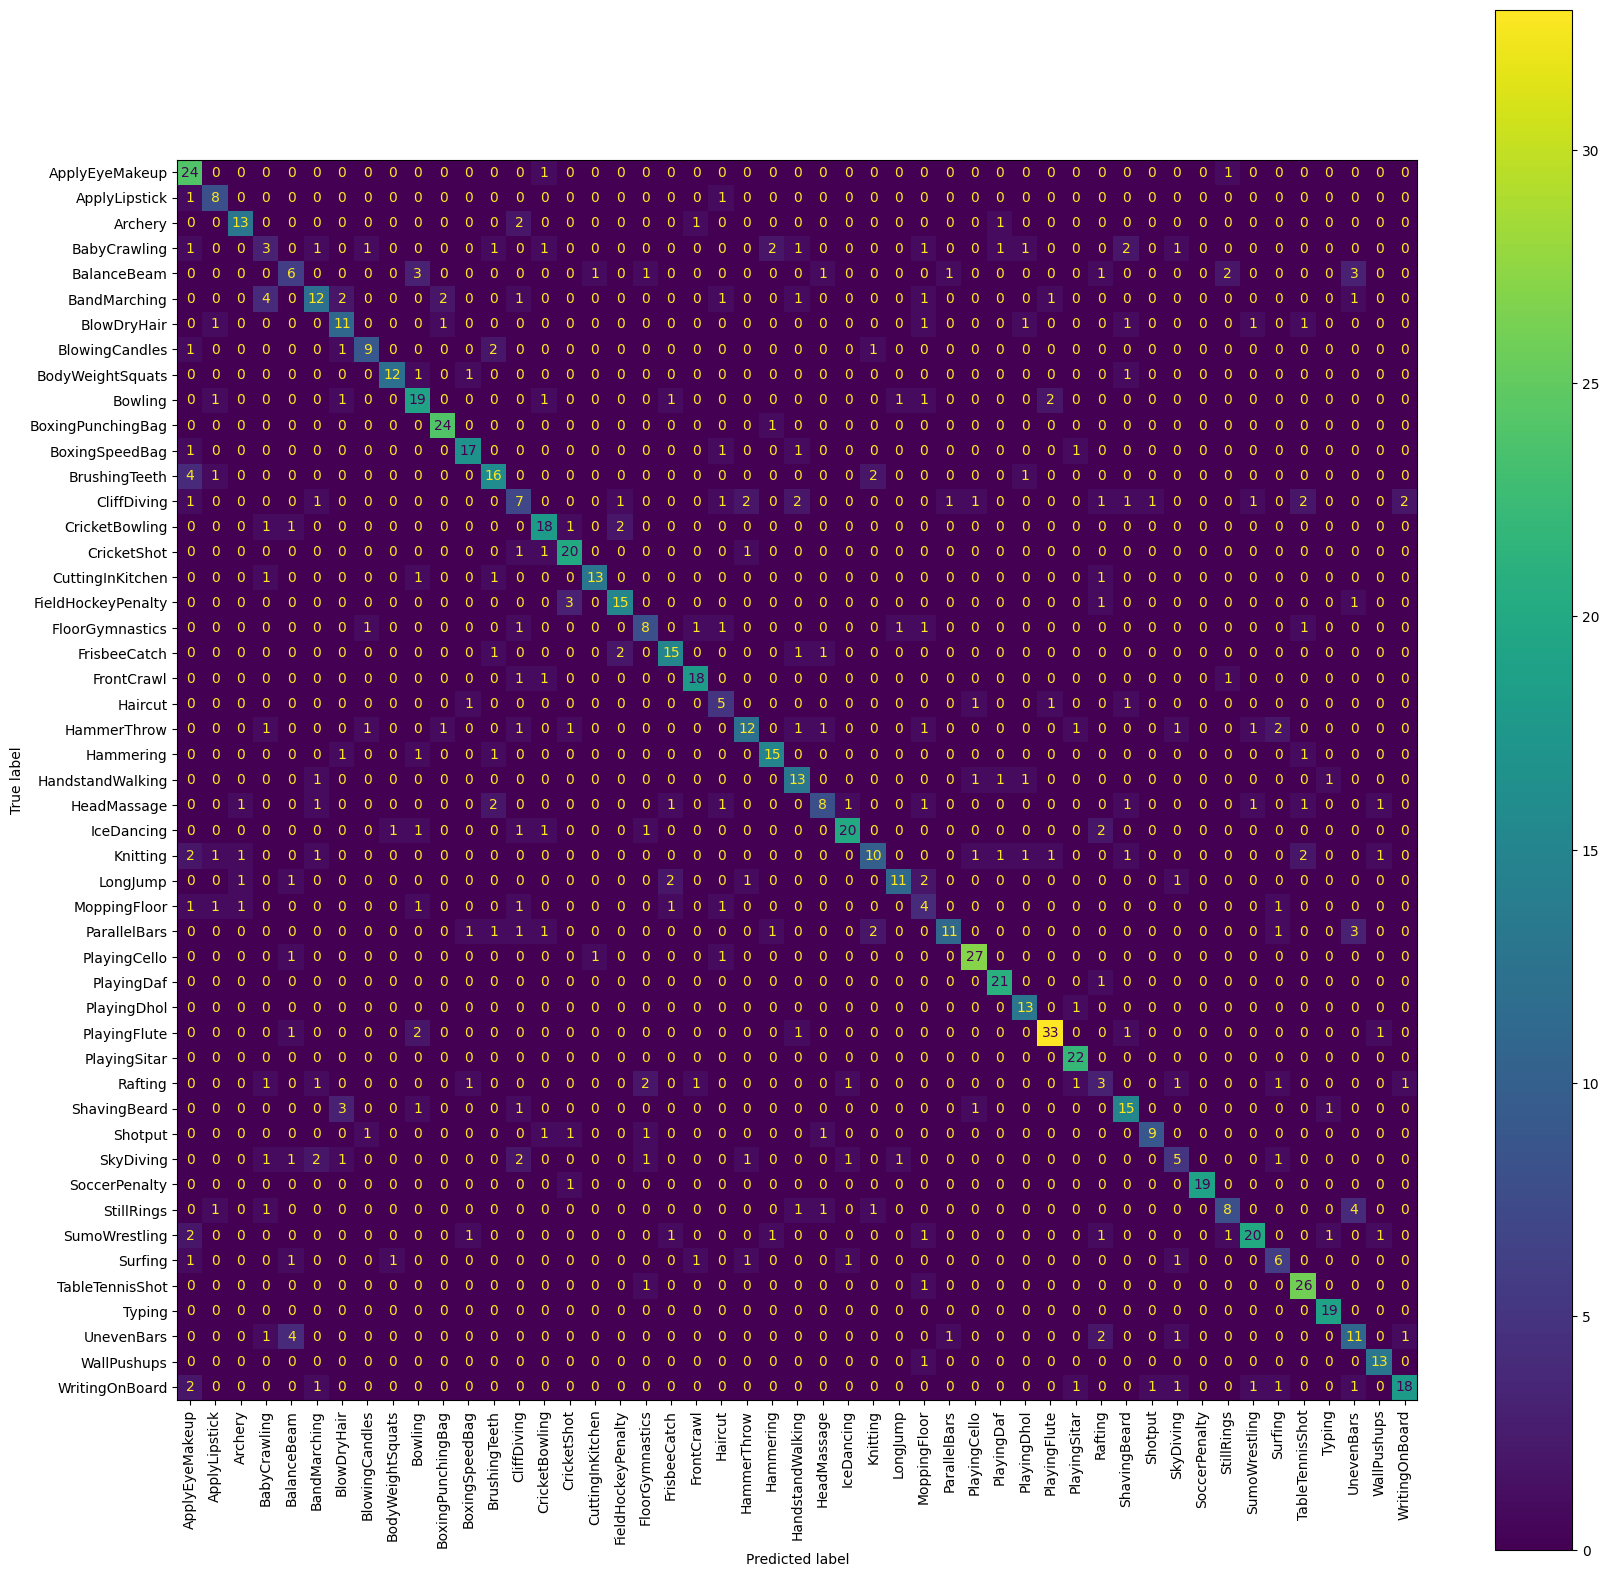

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(all_dataset.label2id.keys())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax, xticks_rotation='vertical')